# SAIGONQUANT - JUPYTER NOTEBOOK

In order to run this notebook, these files are needed to download (attached in submission):
- utils.py (backend file)
- target_prices.xlsx
- F-F_Research_Data_Factors_daily.csv

(note that .env is not needed as we have already adjusted for public run)

# Import Dependencies

In [ ]:
from utils import * # backend file
# from dotenv import load_dotenv # load config
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.covariance import ShrunkCovariance,\
	empirical_covariance, log_likelihood
from scipy import linalg
from sklearn.model_selection import GridSearchCV
import random
from sklearn.preprocessing import QuantileTransformer
from pypfopt import black_litterman, risk_models, \
    BlackLittermanModel, plotting, DiscreteAllocation, \
    EfficientFrontier, objective_functions
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from joblib import dump, load
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from scipy.stats import gaussian_kde
from collections import OrderedDict
import scipy.stats as stats

np.random.seed(42)

In [546]:
# load_dotenv()

In [547]:
# already modified for public run without .env file
username = int(os.getenv('MT5_USERNAME'))
password = os.getenv('MT5_PASSWORD')
server = os.getenv('MT5_SERVER')
api_key = os.getenv('BINANCE_API')
api_secret = os.getenv('BINANCE_SECRET_API')

In [548]:
datafetcher = DataFetcher(username, password, server, api_key, api_secret)
dataprocessor = DataProcessor()

In [549]:
datafetcher.get_investor_data()

Investor Profile
----------------
Name: Emily Chen
Age: 29
Background: Tech Startup Manager, actively investing for several years

Assets:
  1. High growth stocks: $150,000
  2. Equity in tech startup stock options: $200,000
  3. Retirement account: $50,000

Liabilities:
  1. Car loan: $30,000
  2. Student loan: $15,000


# Instruments List

In [550]:
tickers_dict = {
    "us_tech_stocks": ['IBM', 'CRM', 'AAPL', 'MSFT', 'DELL', 'ORCL', 'ADBE', 'NVDA', 'AMD', 'INTU'],
    "emerging_markets_stocks": ['TSM', 'BABA', 'INFY', 'PDD', 'ABEV', 'IBN', 'BBD', 'CICHY', 'PBR'],
    "renewables": ['FSLR', 'DUK', 'PEG', 'BE', 'TSLA', 'PCG', 'NEE'],
    "cash_equivalents": ['SHV', 'BIL']
}

# Historical Bars

In [551]:
all_data = {}
start_date = '2018-01-01'
end_date = '2023-12-01'

for category, tickers in tickers_dict.items():
    print(f"Fetching data for category: {category}")
    all_data[category] = datafetcher.yfinance_adj_close(tickers, start=start_date, end=end_date)

df = pd.concat(all_data.values(), axis=1)
df.ffill(inplace=True)
df.bfill(inplace=True)
df

Fetching data for category: us_tech_stocks
Fetching data for ['IBM', 'CRM', 'AAPL', 'MSFT', 'DELL', 'ORCL', 'ADBE', 'NVDA', 'AMD', 'INTU'] from 2018-01-01 to 2023-12-01 with interval '1d'


[*********************100%%**********************]  10 of 10 completed
[***********           22%%                      ]  2 of 9 completed

Fetching data for category: emerging_markets_stocks
Fetching data for ['TSM', 'BABA', 'INFY', 'PDD', 'ABEV', 'IBN', 'BBD', 'CICHY', 'PBR'] from 2018-01-01 to 2023-12-01 with interval '1d'


[*********************100%%**********************]  9 of 9 completed
[                       0%%                      ]

Fetching data for category: renewables
Fetching data for ['FSLR', 'DUK', 'PEG', 'BE', 'TSLA', 'PCG', 'NEE'] from 2018-01-01 to 2023-12-01 with interval '1d'


[*********************100%%**********************]  7 of 7 completed
[                       0%%                      ]

Fetching data for category: cash_equivalents
Fetching data for ['SHV', 'BIL'] from 2018-01-01 to 2023-12-01 with interval '1d'


[*********************100%%**********************]  2 of 2 completed


Ticker,AAPL,ADBE,AMD,CRM,DELL,IBM,INTU,MSFT,NVDA,ORCL,...,TSM,BE,DUK,FSLR,NEE,PCG,PEG,TSLA,BIL,SHV
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,40.524345,177.699997,10.980000,103.948540,21.592663,106.689575,151.132462,79.633522,4.929881,41.771633,...,34.413372,25.00,62.175224,70.430000,32.770107,44.390045,40.448612,21.368668,78.782944,94.567200
2018-01-03,40.517277,181.039993,11.550000,104.824646,21.820559,109.622276,151.551437,80.004120,5.254336,42.739098,...,34.992226,25.00,61.981010,69.800003,32.074932,43.671665,40.242409,21.150000,78.800201,94.567200
2018-01-04,40.705490,183.220001,12.120000,106.208504,22.208248,111.842514,154.265167,80.708275,5.282032,43.160122,...,34.807671,25.00,61.495430,69.139999,31.910128,43.422226,39.060677,20.974667,78.808769,94.584351
2018-01-05,41.168941,185.339996,11.880000,107.622231,22.370657,112.388908,156.264771,81.708893,5.326795,43.419903,...,35.621429,25.00,61.211559,69.169998,32.055927,44.190498,39.385853,21.105333,78.808769,94.584351
2018-01-08,41.016014,185.039993,12.280000,108.378868,22.365419,113.066757,156.360016,81.792274,5.490011,43.876770,...,35.604652,25.00,61.405792,69.620003,32.320053,45.128380,39.504814,22.427334,78.817429,94.584351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24,189.043869,619.429993,122.309998,223.388290,73.276596,149.765961,560.718079,374.628540,47.758259,114.845558,...,96.316833,13.21,87.180229,154.380005,55.921597,17.979513,62.915550,235.449997,86.833855,104.541199
2023-11-27,188.864746,619.270020,122.650002,223.796478,73.325829,150.142365,557.894897,375.799774,48.224087,115.062912,...,95.706421,13.01,87.362778,154.649994,55.950752,17.859783,62.287270,236.080002,86.843292,104.560135
2023-11-28,189.471771,623.320007,122.010002,223.925919,72.902367,150.219559,561.712158,379.859467,47.803238,114.835678,...,96.464516,13.55,87.554932,155.020004,56.514339,17.460684,62.248608,246.720001,86.862221,104.588524


## Historical Market Cap

In [552]:
all_caps = {}
start_date = '2018-01-01'
end_date = '2023-12-01'

for category, tickers in tickers_dict.items():
    if category == 'cash_equivalents':
        continue
    
    print(f"Fetching marketCap data for category: {category}")
    market_caps = {}
    
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        data = stock.history(start=start_date, end=end_date)
        
        outstanding_shares = stock.info.get('sharesOutstanding', None)
        
        if outstanding_shares is not None:
            market_cap_series = data['Close'] * outstanding_shares
            market_caps[ticker] = market_cap_series
        else:
            print(f"Warning: {ticker} has no outstanding shares data.")
            market_caps[ticker] = pd.Series([None] * len(data), index=data.index)
    
    all_caps[category] = pd.DataFrame(market_caps)

caps = pd.concat(all_caps.values(), axis=1)
caps.ffill(inplace=True)
caps.bfill(inplace=True)
caps

Fetching marketCap data for category: us_tech_stocks
Fetching marketCap data for category: emerging_markets_stocks
Fetching marketCap data for category: renewables


,IBM,CRM,AAPL,MSFT,DELL,ORCL,ADBE,NVDA,AMD,INTU,...,BBD,CICHY,PBR,FSLR,DUK,PEG,BE,TSLA,PCG,NEE
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02 00:00:00-05:00,9.864998e+10,9.947875e+10,6.125579e+11,5.920657e+11,7.719701e+09,1.157517e+11,7.822354e+10,1.207328e+11,1.781845e+10,4.230454e+10,...,3.280315e+10,5.654898e+09,1.359383e+10,7.540095e+09,4.802924e+10,2.015251e+10,5.714400e+09,6.859471e+10,1.185769e+11,6.738845e+10
2018-01-03 00:00:00-05:00,1.013617e+11,1.003172e+11,6.124510e+11,5.948210e+11,7.801177e+09,1.184326e+11,7.969381e+10,1.286787e+11,1.874346e+10,4.242182e+10,...,3.325438e+10,5.699590e+09,1.393686e+10,7.472649e+09,4.787921e+10,2.004977e+10,5.714400e+09,6.789277e+10,1.166579e+11,6.595889e+10
2018-01-04 00:00:00-05:00,1.034146e+11,1.016415e+11,6.152960e+11,6.000563e+11,7.939782e+09,1.195993e+11,8.065344e+10,1.293570e+11,1.966846e+10,4.318144e+10,...,3.350162e+10,5.800889e+09,1.397497e+10,7.401990e+09,4.750411e+10,1.946101e+10,5.714400e+09,6.732994e+10,1.159916e+11,6.561999e+10
2018-01-05 00:00:00-05:00,1.039198e+11,1.029945e+11,6.223015e+11,6.074958e+11,7.997846e+09,1.203192e+11,8.158667e+10,1.304532e+11,1.927898e+10,4.374116e+10,...,3.390338e+10,5.833662e+09,1.407661e+10,7.405202e+09,4.728483e+10,1.962302e+10,5.714400e+09,6.774939e+10,1.180439e+11,6.591981e+10
2018-01-08 00:00:00-05:00,1.045466e+11,1.037186e+11,6.199898e+11,6.081157e+11,7.995973e+09,1.215852e+11,8.145461e+10,1.344504e+11,1.992811e+10,4.376783e+10,...,3.365614e+10,5.797910e+09,1.425447e+10,7.453378e+09,4.743487e+10,1.968229e+10,5.714400e+09,7.199309e+10,1.205492e+11,6.646296e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24 00:00:00-05:00,1.384803e+11,2.137826e+11,2.857549e+12,2.785318e+12,2.619748e+10,3.182439e+11,2.726731e+11,1.169600e+12,1.984859e+11,1.569545e+11,...,1.578378e+10,5.187669e+09,5.050540e+10,1.652761e+10,6.734516e+10,3.134610e+10,3.019489e+09,7.558086e+11,4.802777e+10,1.149972e+11
2023-11-27 00:00:00-05:00,1.388284e+11,2.141732e+11,2.854842e+12,2.794026e+12,2.621508e+10,3.188462e+11,2.726027e+11,1.181008e+12,1.990376e+11,1.561643e+11,...,1.568811e+10,5.165462e+09,5.020889e+10,1.655652e+10,6.748617e+10,3.103307e+10,2.973774e+09,7.578310e+11,4.770794e+10,1.150571e+11
2023-11-28 00:00:00-05:00,1.388998e+11,2.142971e+11,2.864017e+12,2.824210e+12,2.606369e+10,3.182166e+11,2.743855e+11,1.170701e+12,1.979990e+11,1.572328e+11,...,1.611858e+10,5.152137e+09,5.103253e+10,1.659613e+10,6.763461e+10,3.101381e+10,3.097205e+09,7.919860e+11,4.664185e+10,1.162161e+11


## Market Cap as of the end of 2023

In [ ]:
caps_dict = caps.iloc[-1].to_dict()
caps_dict

{'IBM': 141496616049.79297,
 'CRM': 240002840194.70215,
 'AAPL': 2857248464587.8906,
 'MSFT': 2796240261816.4062,
 'DELL': 26711503393.125,
 'ORCL': 318134436858.7383,
 'ADBE': 268966606298.82812,
 'NVDA': 1144971979088.875,
 'AMD': 196619663604.34766,
 'INTU': 159010824641.76562,
 'TSM': 496896689075.3906,
 'BABA': 172527198843.33984,
 'INFY': 70441688500.26025,
 'PDD': 204760259267.67188,
 'ABEV': 40925746760.1709,
 'IBN': 77560875946.96875,
 'BBD': 15927265237.677246,
 'CICHY': 5116605180.646179,
 'PBR': 50307730699.00513,
 'FSLR': 16891611109.313965,
 'DUK': 68488108191.10791,
 'PEG': 30065095061.48755,
 'BE': 3300637344.0856934,
 'TSLA': 770671218360.3555,
 'PCG': 45762314856.44531,
 'NEE': 116915452221.67969}

## Risk-free rate

In [554]:
ticker = "^IRX"

start_date = "2018-01-01"
end_date = "2023-12-01"

rf = yf.download(ticker, start=start_date, end=end_date)
rf = rf[['Adj Close']]
rf = rf.rename(columns={'Adj Close': 'rf'})
rf

[*********************100%%**********************]  1 of 1 completed


,rf
Date,
2018-01-02,1.378
2018-01-03,1.370
2018-01-04,1.370
2018-01-05,1.370
2018-01-08,1.380
...,...
2023-11-24,5.253
2023-11-27,5.258
2023-11-28,5.260


In [555]:
rolling_rf = rf.rolling(window=252).mean()
rolling_rf

,rf
Date,
2018-01-02,NaN
2018-01-03,NaN
2018-01-04,NaN
2018-01-05,NaN
2018-01-08,NaN
...,...
2023-11-24,4.941512
2023-11-27,4.945710
2023-11-28,4.950016


# Asset Allocation

## VCV Estimation

### Price Matrix

In [556]:
selected_tickers = tickers_dict['us_tech_stocks'] + tickers_dict['emerging_markets_stocks'] + tickers_dict['renewables']

filtered_df = df[selected_tickers]
filtered_df

Ticker,IBM,CRM,AAPL,MSFT,DELL,ORCL,ADBE,NVDA,AMD,INTU,...,BBD,CICHY,PBR,FSLR,DUK,PEG,BE,TSLA,PCG,NEE
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,106.689575,103.948540,40.524345,79.633522,21.592663,41.771633,177.699997,4.929881,10.980000,151.132462,...,6.194148,11.788823,3.653156,70.430000,62.175224,40.448612,25.00,21.368668,44.390045,32.770107
2018-01-03,109.622276,104.824646,40.517277,80.004120,21.820559,42.739098,181.039993,5.254336,11.550000,151.551437,...,6.279351,11.881992,3.745339,69.800003,61.981010,40.242409,25.00,21.150000,43.671665,32.074932
2018-01-04,111.842514,106.208504,40.705490,80.708275,22.208248,43.160122,183.220001,5.282032,12.120000,154.265167,...,6.326037,12.093171,3.755582,69.139999,61.495430,39.060677,25.00,20.974667,43.422226,31.910128
2018-01-05,112.388908,107.622231,41.168941,81.708893,22.370657,43.419903,185.339996,5.326795,11.880000,156.264771,...,6.401901,12.161494,3.782895,69.169998,61.211559,39.385853,25.00,21.105333,44.190498,32.055927
2018-01-08,113.066757,108.378868,41.016014,81.792274,22.365419,43.876770,185.039993,5.490011,12.280000,156.360016,...,6.355216,12.086962,3.830693,69.620003,61.405792,39.504814,25.00,22.427334,45.128380,32.320053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24,149.765961,223.388290,189.043869,374.628540,73.276596,114.845558,619.429993,47.758259,122.309998,560.718079,...,2.980416,10.814786,13.572634,154.380005,87.180229,62.915550,13.21,235.449997,17.979513,55.921597
2023-11-27,150.142365,223.796478,188.864746,375.799774,73.325829,115.062912,619.270020,48.224087,122.650002,557.894897,...,2.962352,10.768490,13.492951,154.649994,87.362778,62.287270,13.01,236.080002,17.859783,55.950752
2023-11-28,150.219559,223.925919,189.471771,379.859467,72.902367,114.835678,623.320007,47.803238,122.010002,561.712158,...,3.043636,10.740712,13.714293,155.020004,87.554932,62.248608,13.55,246.720001,17.460684,56.514339


### Log Returns

In [557]:
log_returns = dataprocessor.return_from_prices(filtered_df, log_returns=True)
log_returns.dropna(inplace=True)
log_returns

Ticker,IBM,CRM,AAPL,MSFT,DELL,ORCL,ADBE,NVDA,AMD,INTU,...,BBD,CICHY,PBR,FSLR,DUK,PEG,BE,TSLA,PCG,NEE
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-03,0.027117,0.008393,-0.000174,0.004643,0.010499,0.022897,0.018621,0.063739,0.050610,0.002768,...,0.013662,0.007872,0.024921,-0.008985,-0.003129,-0.005111,0.000000,-0.010286,-0.016316,-0.021442
2018-01-04,0.020051,0.013115,0.004635,0.008763,0.017611,0.009803,0.011970,0.005257,0.048172,0.017748,...,0.007407,0.017617,0.002731,-0.009501,-0.007865,-0.029805,0.000000,-0.008325,-0.005728,-0.005151
2018-01-05,0.004873,0.013223,0.011321,0.012322,0.007286,0.006001,0.011504,0.008439,-0.020001,0.012879,...,0.011921,0.005634,0.007246,0.000434,-0.004627,0.008290,0.000000,0.006210,0.017538,0.004559
2018-01-08,0.006013,0.007006,-0.003722,0.001020,-0.000234,0.010467,-0.001620,0.030181,0.033116,0.000609,...,-0.007319,-0.006147,0.012556,0.006485,0.003168,0.003016,0.000000,0.060755,0.021002,0.008206
2018-01-09,0.002200,0.002660,-0.000115,-0.000680,-0.012967,0.005519,0.008931,-0.000270,-0.038179,0.006268,...,-0.016667,-0.001028,-0.007156,0.005729,-0.011748,-0.003620,0.000000,-0.008118,-0.008660,-0.007349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24,0.000322,0.002410,-0.007029,-0.001112,-0.003622,0.000086,-0.000468,-0.019484,-0.001634,-0.000284,...,0.024541,0.000857,0.001959,-0.034005,0.004197,0.006783,0.006836,0.005280,0.002779,0.001391
2023-11-27,0.002510,0.001826,-0.000948,0.003122,0.000672,0.001891,-0.000258,0.009707,0.002776,-0.005048,...,-0.006079,-0.004290,-0.005888,0.001747,0.002092,-0.010036,-0.015256,0.002672,-0.006682,0.000521
2023-11-28,0.000514,0.000578,0.003209,0.010745,-0.005792,-0.001977,0.006519,-0.008765,-0.005232,0.006819,...,0.027069,-0.002583,0.016271,0.002390,0.002197,-0.000621,0.040668,0.044083,-0.022600,0.010023


### Finding the Optimal Shrinkage Intensity (Delta)

#### Quantile Scaling

In [558]:
scaler = QuantileTransformer(output_distribution='uniform')
scaled_df = pd.DataFrame(scaler.fit_transform(filtered_df), columns=filtered_df.columns, index=filtered_df.index)

print(scaled_df)

Ticker           IBM       CRM      AAPL      MSFT      DELL      ORCL  \
Date                                                                     
2018-01-02  0.489514  0.000469  0.048285  0.000828  0.111316  0.037983   
2018-01-03  0.546251  0.001249  0.047896  0.001217  0.116273  0.067127   
2018-01-04  0.586652  0.002047  0.051148  0.002029  0.126847  0.077986   
2018-01-05  0.595014  0.004676  0.067685  0.006017  0.132204  0.085750   
2018-01-08  0.602764  0.006862  0.065086  0.007357  0.132019  0.103472   
...              ...       ...       ...       ...       ...       ...   
2023-11-24  0.997053  0.791644  0.983052  0.995996  0.997763  0.976111   
2023-11-27  0.997994  0.794818  0.981721  0.997993  0.997978  0.978130   
2023-11-28  0.998166  0.795707  0.985848  1.000000  0.996395  0.975714   
2023-11-29  0.999147  0.825903  0.979163  0.998884  0.999186  0.973974   
2023-11-30  1.000000  0.917115  0.982888  0.999007  1.000000  0.973974   

Ticker          ADBE      NVDA       

#### Train-Test split

In [559]:
base_X_train = scaled_df.loc[:'2021-01-01']
base_X_test = scaled_df.loc['2021-01-01':]

#### Feature Transformation

In [560]:
np.random.seed(42)
colorMatrix = VcvEstimation().color_matrix(VcvEstimation().get_number_of_features(tickers_dict))
X_train = np.dot(base_X_train, colorMatrix)
X_test = np.dot(base_X_test, colorMatrix)

#### Optimal Shrinkage (Delta)

In [561]:
shrinkageFactor = VcvEstimation().shrinkage_factor()
negative_logliks = VcvEstimation().negative_log_likelihood(shrinkageFactor, X_train, X_test)
realCovariance = VcvEstimation().real_covariance(colorMatrix)
empiricalCovariance = empirical_covariance(X_train)
logRealLikelihood = VcvEstimation().log_real_likelihood(empiricalCovariance, realCovariance)

tunedParameters = [{"shrinkage": shrinkageFactor}]
cv, optimal_shrinkage_coef = VcvEstimation().get_optimal_shrinkage_coefficient(tunedParameters, X_train)
print(f"Optimal shrinkage coefficient: {optimal_shrinkage_coef}")

Optimal shrinkage coefficient: 0.26263635276533326


In [562]:
cv

GridSearchCV(estimator=ShrunkCovariance(),
             param_grid=[{'shrinkage': array([0.01      , 0.01160155, 0.0134596 , 0.01561523, 0.01811609,
       0.02101748, 0.02438354, 0.02828869, 0.03281928, 0.03807546,
       0.04417345, 0.05124806, 0.05945571, 0.06897785, 0.08002502,
       0.09284145, 0.10771051, 0.12496091, 0.14497407, 0.16819243,
       0.19512934, 0.22638034, 0.26263635, 0.30469896, 0.35349811,
       0.41011271, 0.47579443, 0.55199543, 0.64040043, 0.74296395,
       0.86195357, 1.        ])}])

#### Cross-Validation Plotting

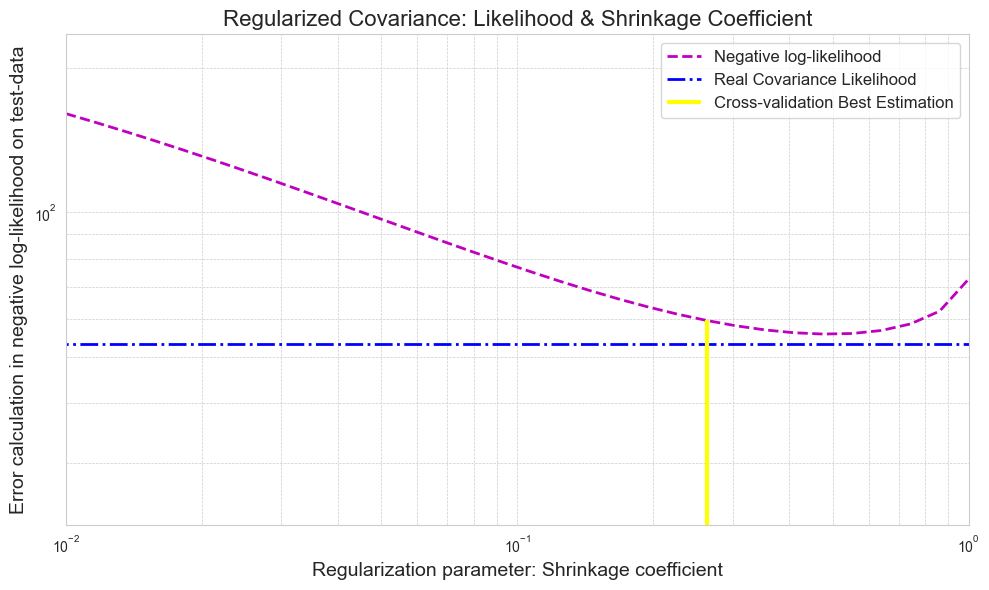

In [563]:
plt.figure(figsize=(10, 6))

plt.loglog(
    shrinkageFactor,
    negative_logliks,
    "m--",
    label="Negative log-likelihood",
    linewidth=2
)

plt.plot(
    plt.xlim(),
    2 * [logRealLikelihood],
    "b-.",
    label="Real Covariance Likelihood",
    linewidth=2 
)

maxLikelihood = np.amax(negative_logliks)
minLikelihood = np.amin(negative_logliks)
min_y = minLikelihood - 7.0 * np.log((plt.ylim()[1] - plt.ylim()[0]))
max_y = maxLikelihood + 16.0 * np.log(maxLikelihood - minLikelihood)
min_x = shrinkageFactor[0]
max_x = shrinkageFactor[-1]

plt.vlines(
    cv.best_estimator_.shrinkage, min_y,
    -cv.best_estimator_.score(X_test),
    color="yellow",
    linewidth=3,
    label="Cross-validation Best Estimation",
)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.title("Regularized Covariance: Likelihood & Shrinkage Coefficient", fontsize=16)
plt.xlabel("Regularization parameter: Shrinkage coefficient", fontsize=14)
plt.ylabel("Error calculation in negative log-likelihood on test-data", fontsize=14)

plt.ylim(min_y, max_y)
plt.xlim(min_x, max_x)

plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()

### Estimated VCV matrix using Ledoit-Wolf Shrinkage Method (with Backtested Optimal Delta)

In [564]:
cov_estimator = CovarianceShrinkage(log_returns, returns_data = True, delta = optimal_shrinkage_coef)
cov_matrix = cov_estimator.ledoit_wolf()
cov_matrix

Ticker,IBM,CRM,AAPL,MSFT,DELL,ORCL,ADBE,NVDA,AMD,INTU,...,BBD,CICHY,PBR,FSLR,DUK,PEG,BE,TSLA,PCG,NEE
Ticker,,,,,,,,,,,,,,,,,,,,,
IBM,0.071874,0.034720,0.036669,0.036175,0.044602,0.036991,0.036741,0.046452,0.047190,0.039299,...,0.044312,0.020712,0.053113,0.029824,0.027357,0.029008,0.049774,0.034069,0.038023,0.025393
CRM,0.034720,0.143249,0.069214,0.077023,0.058749,0.050944,0.098975,0.112540,0.103935,0.090527,...,0.040765,0.025634,0.051110,0.059616,0.020323,0.024090,0.103865,0.101286,0.044256,0.032798
AAPL,0.036669,0.069214,0.103798,0.071038,0.056578,0.047493,0.077109,0.103235,0.094696,0.073423,...,0.044964,0.025756,0.055092,0.050125,0.023923,0.026702,0.082694,0.094074,0.039007,0.033553
MSFT,0.036175,0.077023,0.071038,0.094204,0.055302,0.051070,0.085583,0.106749,0.094918,0.079988,...,0.043450,0.026357,0.051220,0.049699,0.023409,0.024911,0.081327,0.085795,0.040694,0.034199
DELL,0.044602,0.058749,0.056578,0.055302,0.149232,0.045050,0.060118,0.088098,0.083536,0.059439,...,0.051216,0.023907,0.062989,0.047026,0.021556,0.030432,0.095240,0.070961,0.053198,0.028016
ORCL,0.036991,0.050944,0.047493,0.051070,0.045050,0.089260,0.056241,0.067946,0.064925,0.053046,...,0.036435,0.021080,0.040760,0.031933,0.024039,0.023104,0.046523,0.045337,0.037225,0.025465
ADBE,0.036741,0.098975,0.077109,0.085583,0.060118,0.056241,0.137172,0.124679,0.113462,0.094606,...,0.041653,0.028064,0.051491,0.060578,0.020028,0.022735,0.099099,0.102789,0.048100,0.035464
NVDA,0.046452,0.112540,0.103235,0.106749,0.088098,0.067946,0.124679,0.264843,0.200322,0.120341,...,0.058761,0.038864,0.071769,0.088098,0.020186,0.026432,0.155705,0.153451,0.042159,0.039810
AMD,0.047190,0.103935,0.094696,0.094918,0.083536,0.064925,0.113462,0.200322,0.301828,0.106517,...,0.052519,0.036787,0.065435,0.083094,0.017828,0.023452,0.132708,0.143551,0.044830,0.036767


## Black-Litterman Optimization

### Target Prices for viewdict (from analyst report)

In [ ]:
target_series = BlackLitterman().get_target_prices(filtered_df) # if error, adjust path in get_target_prices
target_series

Ticker
ADBE     465.00
AMD      130.00
MSFT     385.00
AAPL     225.00
CRM      300.00
IBM      145.00
TSLA     260.00
ORCL     135.00
NVDA      67.50
FSLR     188.00
PCG       20.00
DUK      103.00
NEE       67.00
PEG       70.00
DELL      85.00
INTU     775.00
TSM      105.00
BABA      70.00
PDD      180.00
BBD        4.00
IBN       13.92
ABEV       3.11
PBR        8.72
CICHY     13.00
BE        18.50
INFY      20.00
Name: Target price, dtype: float64

### Market price

In [566]:
start_date = '2018-01-01'
end_date = '2023-12-01'

market_prices = yf.download("SPY", start=start_date, end=end_date)["Adj Close"]
market_prices.head()

[*********************100%%**********************]  1 of 1 completed


Date
2018-01-02    240.801529
2018-01-03    242.324661
2018-01-04    243.346008
2018-01-05    244.967651
2018-01-08    245.415573
Name: Adj Close, dtype: float64

### Market Risk Aversion

In [567]:
S = cov_matrix
risk_free = rolling_rf.iloc[-1].values.item() / 100
delta = black_litterman.market_implied_risk_aversion(market_prices, risk_free_rate=risk_free)
delta

1.8461972435783385

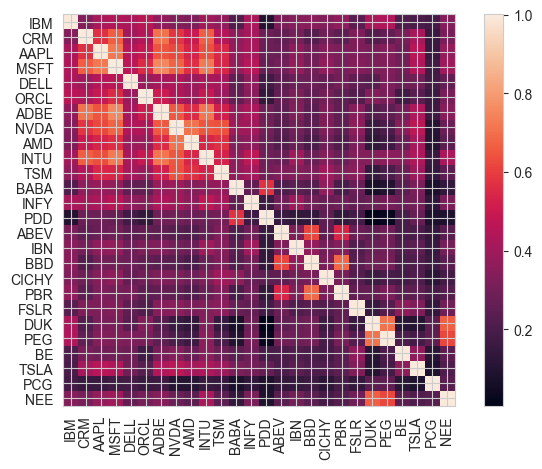

In [568]:
plotting.plot_covariance(S, plot_correlation=True);

### Market-Implied Prior

In [569]:
market_prior = black_litterman.market_implied_prior_returns(caps_dict, delta, S, risk_free)

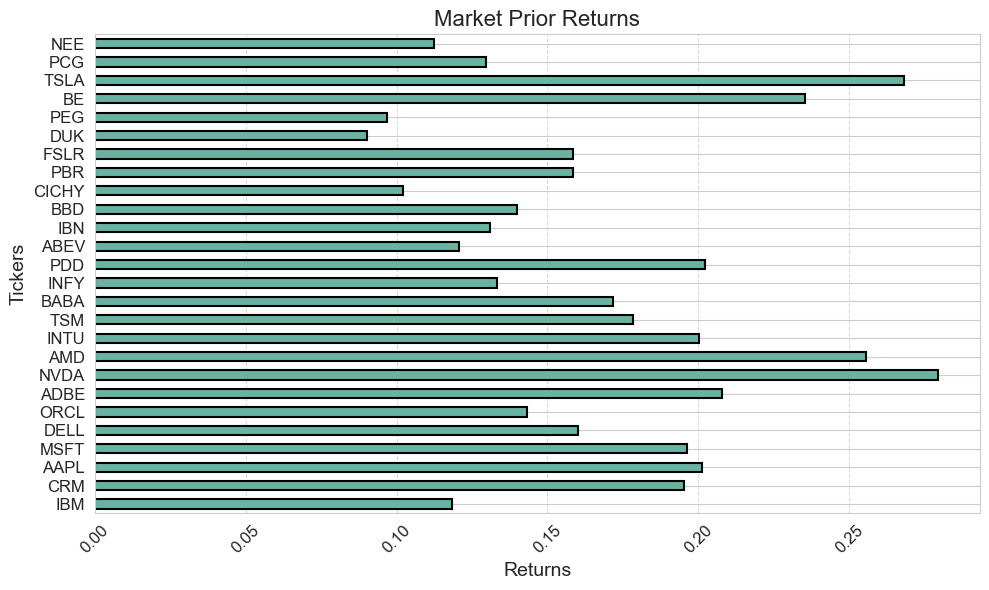

In [570]:
BlackLitterman().plot_market_prior(market_prior=market_prior)

### Expected Views

In [571]:
last_row = filtered_df.iloc[-1]
sorted_target = target_series.reindex(last_row.index)
expt_returns = (sorted_target - last_row) / last_row
expt_returns.to_dict()

{'IBM': -0.05246127021992361,
 'CRM': 0.1962358435720607,
 'AAPL': 0.19032521719826848,
 'MSFT': 0.023670547587566176,
 'DELL': 0.13766624187171192,
 'ORCL': 0.17589626377388728,
 'ADBE': -0.23896500455308814,
 'NVDA': 0.44376897960022915,
 'AMD': 0.07296134095987301,
 'INTU': 0.36428239579747385,
 'TSM': 0.09597776916837848,
 'BABA': -0.03201408241928958,
 'INFY': 0.17601102420612671,
 'PDD': 0.22083557392460934,
 'ABEV': 0.19520607141135862,
 'IBN': -0.3667422644666565,
 'BBD': 0.33000359747190794,
 'CICHY': 0.21875323262923074,
 'PBR': -0.35500635888070997,
 'FSLR': 0.19153252284514816,
 'DUK': 0.1617439356038503,
 'PEG': 0.1600079550280468,
 'BE': 0.2811634721327969,
 'TSLA': 0.08297233429281252,
 'PCG': 0.16744527822930816,
 'NEE': 0.1784481638813831}

In [572]:
viewdict = expt_returns
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

### Confidences

In [573]:
confidences = BlackLitterman().get_confidences(viewdict)
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

### Omega

In [574]:
np.diag(bl.omega)

array([0.03234313, 0.00477497, 0.00778487, 0.01099043, 0.00746159,
       0.00297532, 0.0102879 , 0.00147135, 0.13582255, 0.00278303,
       0.02402813, 0.04257785, 0.00301228, 0.02595875, 0.00495557,
       0.00070325, 0.00277274, 0.00276949, 0.00617453, 0.01731874,
       0.00191329, 0.00306154, 0.02570772, 0.04724796, 0.02867632,
       0.00259485])

In [575]:
intervals = []
for confidence in confidences:
    if confidence >= 0.7:
        interval = (confidence - 0.1, confidence + 0.1)
    elif 0.4 <= confidence <= 0.6:
        interval = (confidence - 0.05, confidence + 0.05)
    else:
        interval = (confidence - 0.03, confidence + 0.03)
    
    interval = (max(0, interval[0]), min(1, interval[1]))
    intervals.append(interval)

In [576]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.0009, 0.0025000000000000044, 0.0024999999999999988, 0.0008999999999999982, 0.002500000000000002, 0.0025000000000000044, 0.0024999999999999988, 0.009999999999999995, 0.0009, 0.009999999999999995, 0.0009, 0.0009, 0.0025000000000000044, 0.002500000000000002, 0.0025000000000000044, 0.009999999999999995, 0.009999999999999995, 0.002500000000000002, 0.009999999999999995, 0.0024999999999999988, 0.0025000000000000044, 0.002500000000000002, 0.0025000000000000044, 0.0008999999999999982, 0.002500000000000002, 0.0025000000000000044]


In [577]:
bl = BlackLittermanModel(S, pi="market", market_caps=caps_dict, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

### Black-Litterman Returns

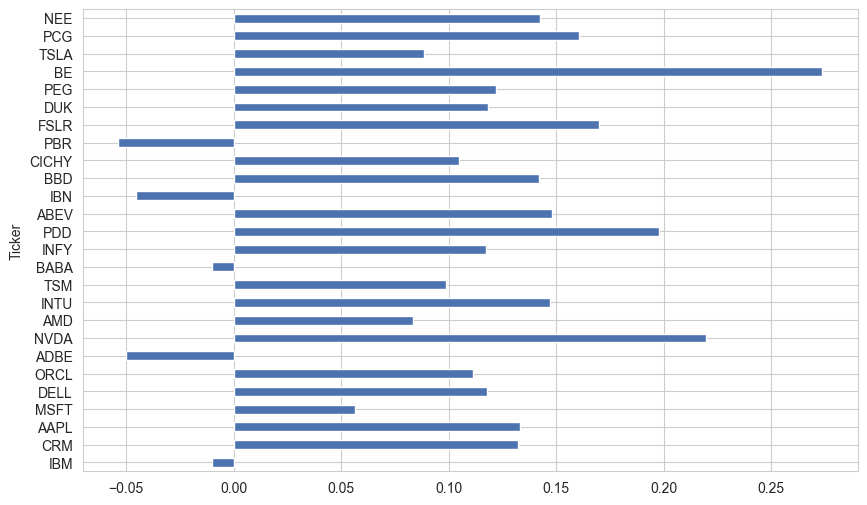

In [578]:
ret_bl = bl.bl_returns()
ret_bl.plot.barh(figsize=(10, 6));

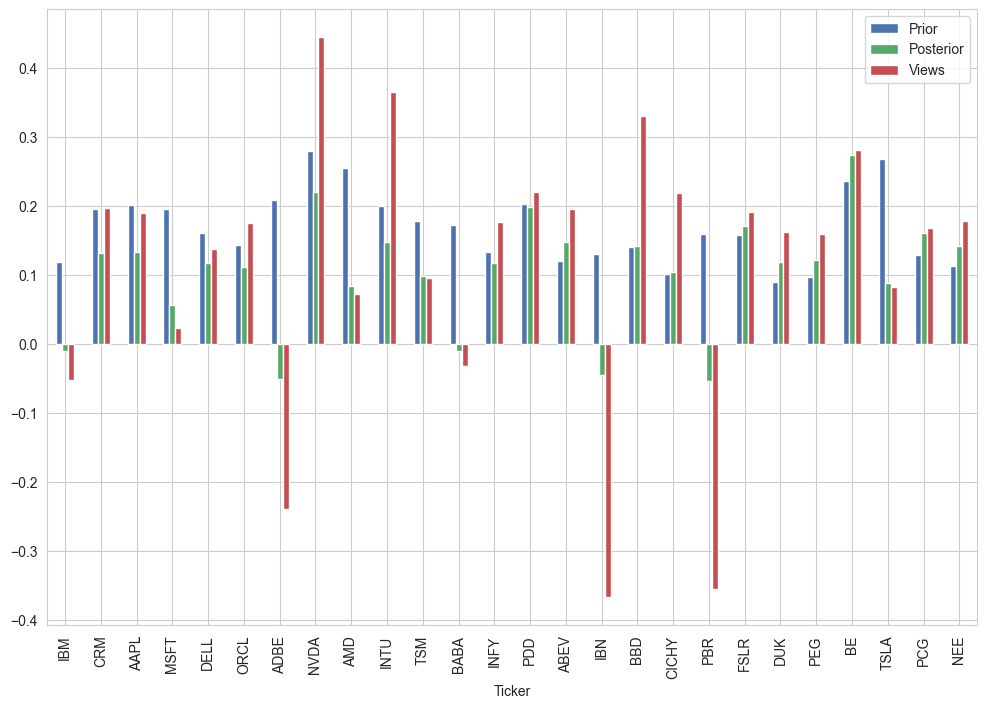

In [579]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df.plot.bar(figsize=(12,8));

In [580]:
S_bl = bl.bl_cov()

### Optimal Weights

In [810]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_constraint(lambda w: w >= 0.0)
ef.add_constraint(lambda w: w <= 0.10)
us_tech_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8]
emerging_markets_indices = [9, 10, 11, 12, 13, 14, 15, 16, 17]
renewable_energy_indices = [18, 19, 20, 21, 22, 23, 24, 25]
ef.add_constraint(lambda w: sum(w[i] for i in us_tech_indices) == 0.7)
ef.add_constraint(lambda w: sum(w[i] for i in emerging_markets_indices) == 0.2)
ef.add_constraint(lambda w: sum(w[i] for i in renewable_energy_indices) == 0.1)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights = {asset: weight for asset, weight in weights.items() if weight > 0}
# weights = {key: value * 100 for key, value in weights.items()}
# weights = {asset: round(weight, 2) for asset, weight in weights.items()}
weights

{'IBM': 0.0295,
 'CRM': 0.1,
 'AAPL': 0.1,
 'MSFT': 0.08937,
 'DELL': 0.1,
 'ORCL': 0.1,
 'NVDA': 0.1,
 'AMD': 0.08113,
 'INTU': 0.02108,
 'INFY': 0.0122,
 'PDD': 0.06836,
 'ABEV': 0.05221,
 'BBD': 0.03388,
 'CICHY': 0.01227,
 'FSLR': 0.0113,
 'BE': 0.07231,
 'PCG': 0.01144,
 'NEE': 0.00495}

In [811]:
(rets_df.loc[weights.keys()] * 100)

,Prior,Posterior,Views
Ticker,,,
IBM,11.846681,-1.015668,-5.246127
CRM,19.530912,13.241926,19.623584
AAPL,20.125755,13.331465,19.032522
MSFT,19.616923,5.631837,2.367055
DELL,16.017832,11.797908,13.766624
ORCL,14.312131,11.150658,17.589626
NVDA,27.937083,21.960502,44.376898
AMD,25.545244,8.337871,7.296134
INTU,20.026251,14.728620,36.428240


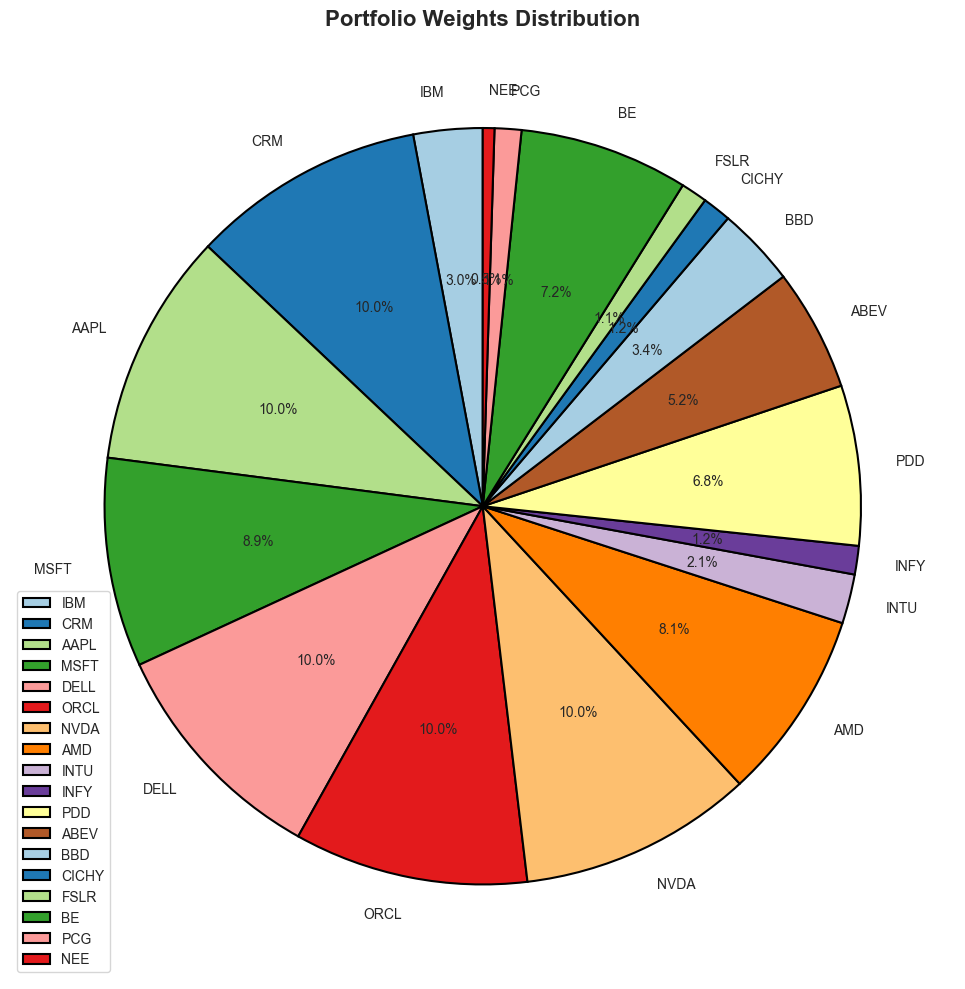

In [812]:
BlackLitterman().plot_portfolio(weights)

In [ ]:
# da = DiscreteAllocation(weights, filtered_df.iloc[-1], total_portfolio_value=310000)
# alloc, leftover = da.greedy_portfolio()
# print(f"Leftover: ${leftover:.2f}")
# alloc

Leftover: $10.06


{'CRM': 123,
 'AAPL': 164,
 'DELL': 414,
 'ORCL': 270,
 'NVDA': 663,
 'MSFT': 74,
 'AMD': 207,
 'BE': 1552,
 'PDD': 143,
 'ABEV': 6220,
 'BBD': 3492,
 'IBM': 60,
 'INTU': 12,
 'CICHY': 356,
 'INFY': 222,
 'PCG': 207,
 'FSLR': 22,
 'NEE': 27}

# Portfolio Theory

## Traditional Approach (FF 3 Factors)

In [814]:
stock_list = list(weights.keys())
stock_weights = list(weights.values())
portfolio = filtered_df[stock_list]
portfolio = np.log(portfolio / portfolio.shift(1))
portfolio.dropna(inplace=True)
portfolio

Ticker,IBM,CRM,AAPL,MSFT,DELL,ORCL,NVDA,AMD,INTU,INFY,PDD,ABEV,BBD,CICHY,FSLR,BE,PCG,NEE
Date,,,,,,,,,,,,,,,,,,
2018-01-03,0.027117,0.008393,-0.000174,0.004643,0.010499,0.022897,0.063739,0.050610,0.002768,-0.008631,0.000000,0.006033,0.013662,0.007872,-0.008985,0.000000,-0.016316,-0.021442
2018-01-04,0.020051,0.013115,0.004635,0.008763,0.017611,0.009803,0.005257,0.048172,0.017748,-0.006211,0.000000,-0.001505,0.007407,0.017617,-0.009501,0.000000,-0.005728,-0.005151
2018-01-05,0.004873,0.013223,0.011321,0.012322,0.007286,0.006001,0.008439,-0.020001,0.012879,0.018519,0.000000,0.004508,0.011921,0.005634,0.000434,0.000000,0.017538,0.004559
2018-01-08,0.006013,0.007006,-0.003722,0.001020,-0.000234,0.010467,0.030181,0.033116,0.000609,0.007920,0.000000,-0.007525,-0.007319,-0.006147,0.006485,0.000000,0.021002,0.008206
2018-01-09,0.002200,0.002660,-0.000115,-0.000680,-0.012967,0.005519,-0.000270,-0.038179,0.006268,0.015653,0.000000,-0.006061,-0.016667,-0.001028,0.005729,0.000000,-0.008660,-0.007349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24,0.000322,0.002410,-0.007029,-0.001112,-0.003622,0.000086,-0.019484,-0.001634,-0.000284,-0.006277,0.010672,-0.003630,0.024541,0.000857,-0.034005,0.006836,0.002779,0.001391
2023-11-27,0.002510,0.001826,-0.000948,0.003122,0.000672,0.001891,0.009707,0.002776,-0.005048,-0.005740,-0.008290,0.003630,-0.006079,-0.004290,0.001747,-0.015256,-0.006682,0.000521
2023-11-28,0.000514,0.000578,0.003209,0.010745,-0.005792,-0.001977,-0.008765,-0.005232,0.006819,0.014857,0.166165,0.010811,0.027069,-0.002583,0.002390,0.040668,-0.022600,0.010023


In [815]:
weights_series = pd.Series(weights)
weighted_returns = portfolio.mul(weights_series, axis=1)
portfolio_returns = weighted_returns.sum(axis=1)
monthly_portfolio_returns = portfolio_returns.resample('M').sum()
monthly_portfolio_returns.index = monthly_portfolio_returns.index.to_period('M')

In [ ]:
ff_factors_daily = FamaFrench().get_factors("F-F_Research_Data_Factors_daily") # adjust path in get_factors if error
ff_factors_daily.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-01,0.10,-0.25,-0.27,0.009
1926-07-02,0.45,-0.33,-0.06,0.009
1926-07-06,0.17,0.30,-0.39,0.009
1926-07-07,0.09,-0.58,0.02,0.009
1926-07-08,0.21,-0.38,0.19,0.009


In [817]:
ff_factors_subset1 = ff_factors_daily[
    ff_factors_daily.index.isin(portfolio_returns.index)
].copy()

ff_factors_subset1["Excess_Return"] = portfolio_returns - ff_factors_subset1["RF"]
ff_factors_subset1 = ff_factors_subset1.resample('M').sum()
ff_factors_subset1

,Mkt-RF,SMB,HML,RF,Excess_Return
Date,,,,,
2018-01-31,4.61,-3.33,-1.02,0.120,-0.055836
2018-02-28,-3.47,0.22,-1.07,0.114,-0.123125
2018-03-31,-2.23,4.05,-0.20,0.105,-0.137642
2018-04-30,0.39,1.09,0.49,0.147,-0.151843
2018-05-31,2.66,5.05,-3.06,0.132,-0.082354
...,...,...,...,...,...
2023-07-31,3.20,1.99,3.96,0.440,-0.396112
2023-08-31,-2.33,-3.28,-1.13,0.460,-0.478773
2023-09-30,-5.30,-2.57,1.52,0.420,-0.468434


In [818]:
X = sm.add_constant(ff_factors_subset1[["Mkt-RF", "SMB", "HML"]])
y = ff_factors_subset1["Excess_Return"]
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     9.195
Date:                Fri, 06 Dec 2024   Prob (F-statistic):           3.55e-05
Time:                        22:23:22   Log-Likelihood:                 43.149
No. Observations:                  71   AIC:                            -78.30
Df Residuals:                      67   BIC:                            -69.25
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1362      0.016     -8.268      0.0

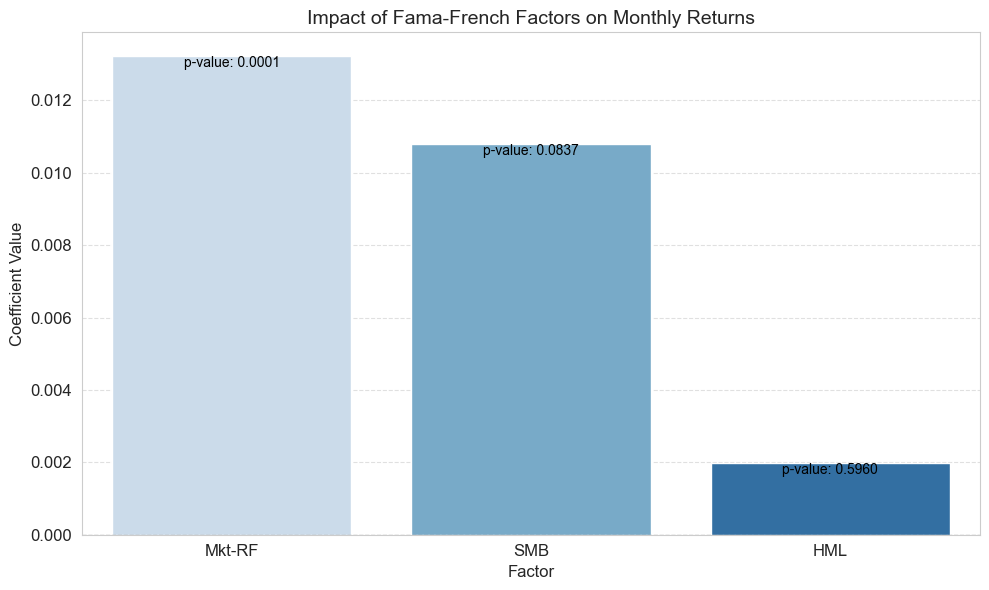

In [819]:
factors = model.params.index[1:]
coefficients = model.params.values[1:]
confidence_intervals = model.conf_int().diff(axis=1).iloc[1]

ols_data = pd.DataFrame(
    {
        "Factor": factors,
        "Coefficient": coefficients,
        "Confidence_Lower": confidence_intervals[0],
        "Confidence_Upper": confidence_intervals[1],
    }
)

FamaFrench().plot_impact(model, ols_data)

## Modern Approach (with Algorithmic Trading)

### Data Model

In [820]:
ff_factors_subset2 = ff_factors_daily[
    ff_factors_daily.index.isin(portfolio_returns.index)
].copy()

ff_factors_subset2["Returns"] = portfolio_returns
ff_factors_subset2.drop(columns=["RF"], inplace=True)
ff_factors_subset2

,Mkt-RF,SMB,HML,Returns
Date,,,,
2018-01-03,0.59,-0.39,-0.18,0.016289
2018-01-04,0.42,-0.26,0.24,0.010813
2018-01-05,0.66,-0.36,-0.26,0.005683
2018-01-08,0.19,-0.15,0.04,0.007072
2018-01-09,0.15,-0.34,-0.03,-0.004252
...,...,...,...,...
2023-11-24,0.11,0.59,0.18,-0.001538
2023-11-27,-0.23,-0.11,-0.08,-0.000077
2023-11-28,0.06,-0.29,0.05,0.015169


### Features and Target

In [821]:
X = ff_factors_subset2.drop(['Returns'], axis=1)
y = ff_factors_subset2.loc[:, 'Returns']

### Train test split

In [822]:
split = int(0.8 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]
test=ff_factors_subset2["Returns"][split:]
test

Date
2022-09-26   -0.013177
2022-09-27    0.005521
2022-09-28    0.014446
2022-09-29   -0.033999
2022-09-30   -0.009222
                ...   
2023-11-24   -0.001538
2023-11-27   -0.000077
2023-11-28    0.015169
2023-11-29    0.007888
2023-11-30    0.009890
Name: Returns, Length: 298, dtype: float64

### Prediction model

In [823]:
lin_reg_model = LinearRegression(fit_intercept=True)
lin_reg_model = lin_reg_model.fit(X_train, y_train)
predictions = lin_reg_model.predict(X_test)

In [824]:
y_test = y_test.to_frame()

In [825]:
signals_df = y_test.copy()

y_test['Predictions'] = predictions
y_test["Returns"]=test

# Add "Buy Signal" column based on whether day's predictions were greater than the day's actual returns:
y_test['Buy Signal'] = np.where(y_test['Predictions'] > y_test['Returns'], 1.0,0.0)

y_test=y_test.dropna()
y_test.head()

,Returns,Predictions,Buy Signal
Date,,,
2022-09-26,-0.013177,-0.009421,1.0
2022-09-27,0.005521,0.003520,0.0
2022-09-28,0.014446,0.028304,1.0
2022-09-29,-0.033999,-0.029300,1.0
2022-09-30,-0.009222,-0.016720,0.0


In [826]:
signals_df = AlgorithmicTrading().generate_signals(y_test)
signals_df.head(10)

,Returns,Predictions,Buy Signal,Position,Entry/Exit,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
Date,,,,,,,,,,,
2022-09-28,0.014446,0.028304,1.0,2000.0,1.0,2000.0,0.000000,99982.149957,99982.149957,-1.785004e-04,-0.000179
2022-09-29,-0.033999,-0.029300,1.0,2000.0,0.0,0.0,-0.000000,99982.149957,99982.149957,0.000000e+00,-0.000179
2022-09-30,-0.009222,-0.016720,0.0,0.0,-1.0,-2000.0,18.444501,99963.705455,99982.149957,0.000000e+00,-0.000179
2022-10-03,0.036557,0.027691,0.0,0.0,0.0,0.0,-73.113023,99963.705455,99890.592433,-9.157387e-04,-0.001094
2022-10-04,0.038278,0.040852,1.0,2000.0,1.0,2000.0,0.000000,99887.149870,99887.149870,-3.446333e-05,-0.001129
2022-10-05,-0.001576,-0.003407,0.0,0.0,-1.0,-2000.0,3.151524,99883.998346,99887.149870,-1.110223e-16,-0.001129
2022-10-06,-0.014683,-0.009618,1.0,2000.0,1.0,2000.0,-0.000000,99913.364947,99913.364947,2.624469e-04,-0.000866
2022-10-07,-0.055652,-0.040982,1.0,2000.0,0.0,0.0,-0.000000,99913.364947,99913.364947,0.000000e+00,-0.000866
2022-10-10,-0.019731,-0.011883,1.0,2000.0,0.0,0.0,-0.000000,99913.364947,99913.364947,0.000000e+00,-0.000866


In [827]:
AlgorithmicTrading().algo_evaluation(signals_df)

,Backtest
Annual Return,0.798256
Cumulative Returns,0.940637
Annual Volatility,0.485366
Sharpe Ratio,1.644647
Sortino Ratio,2.598335


In [828]:
AlgorithmicTrading().algo_vs_underlying(signals_df)

,Algo,Underlying
Annual Return,0.798256,0.427364
Cumulative Returns,0.940637,0.593522
Annual Volatility,0.485366,0.247279
Sharpe Ratio,1.644647,1.728269
Sortino Ratio,2.598335,2.734409


In [829]:
trade_evaluation_df=AlgorithmicTrading().trade_evaluation(signals_df)
trade_evaluation_df

,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss
0,2022-09-28,2022-09-30,2000.0,0.014446,-0.009222,99982.149957,99982.149957,0.000000e+00
1,2022-10-04,2022-10-05,2000.0,0.038278,-0.001576,99887.149870,99887.149870,-1.455192e-11
2,2022-10-06,2022-10-13,2000.0,-0.014683,0.024282,99913.364947,99913.364947,0.000000e+00
3,2022-10-17,2022-10-19,2000.0,0.031270,-0.011338,99899.390605,99899.390605,0.000000e+00
4,2022-10-24,2022-10-26,2000.0,-0.017246,-0.006474,99911.206269,99911.206269,0.000000e+00
...,...,...,...,...,...,...,...,...
74,2023-11-10,2023-11-14,2000.0,0.015120,0.029218,100834.748227,100834.748227,1.455192e-11
75,2023-11-15,2023-11-16,2000.0,-0.001839,0.005152,100896.862296,100896.862296,0.000000e+00
76,2023-11-17,2023-11-20,2000.0,0.002370,0.013671,100902.425958,100902.425958,0.000000e+00
77,2023-11-21,2023-11-22,2000.0,-0.007661,0.006202,100945.088730,100945.088730,-1.455192e-11


In [830]:
AlgorithmicTrading().underlying_returns(signals_df)

,Underlying Cumulative Returns,Algo Cumulative Returns
Date,,
2022-09-28,0.014446,-0.017850
2022-09-29,-0.020043,-0.017850
2022-09-30,-0.029081,-0.017850
2022-10-03,0.006413,-0.109408
2022-10-04,0.044936,-0.112850
...,...,...
2023-11-24,0.542293,0.960570
2023-11-27,0.542175,0.960570
2023-11-28,0.565568,0.930079


<Axes: xlabel='Date'>

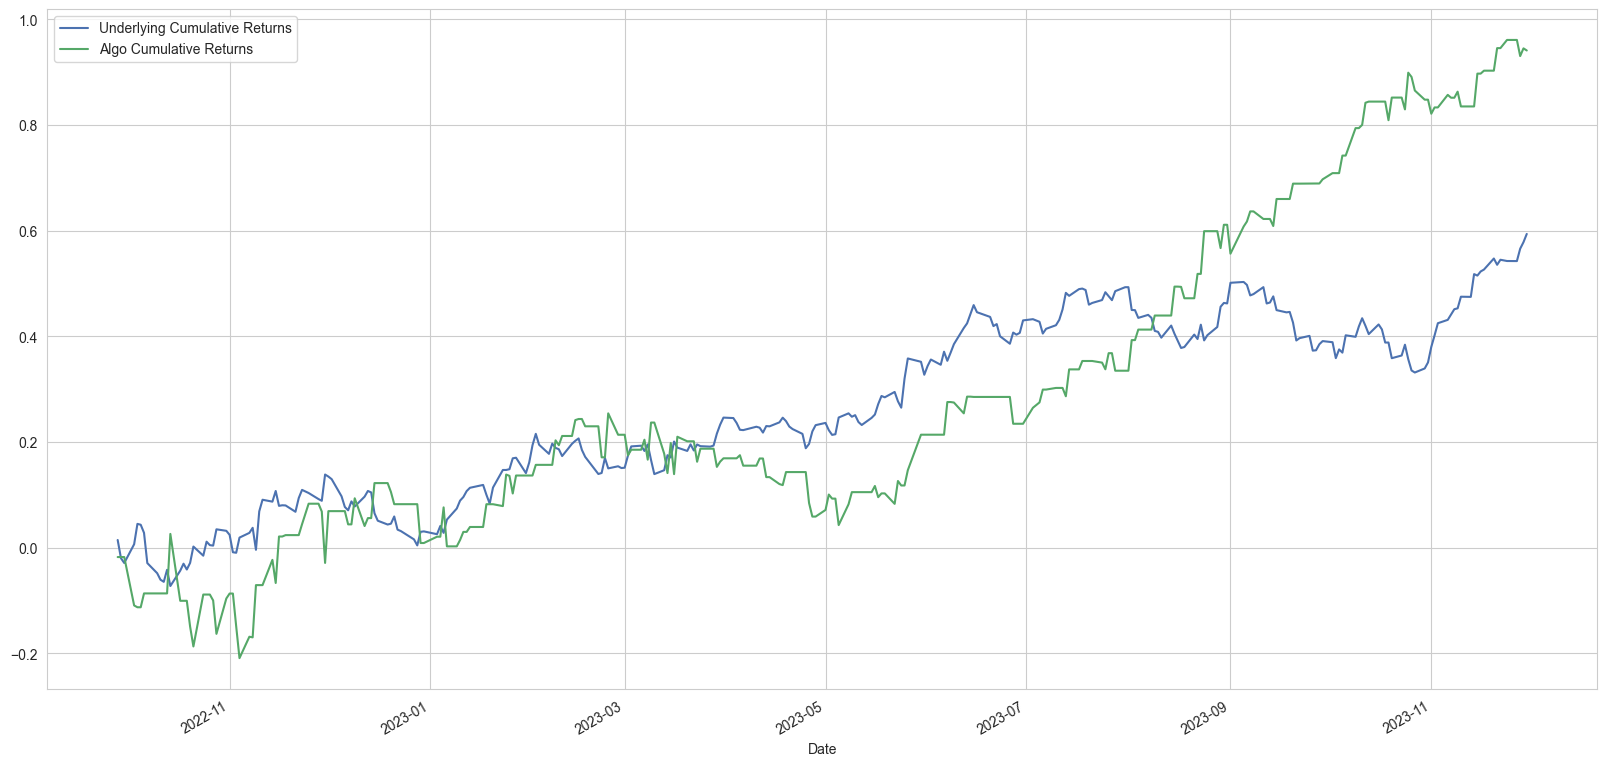

In [831]:
# Generate Cumulative Return plot using above defined function:
AlgorithmicTrading().underlying_returns(signals_df).plot(figsize=(20,10))

## Risk measurements/estimations (VaR using Monte Carlo Simulation Method)

In [832]:
yearly_log_returns = portfolio.resample('Y').sum()
yearly_log_returns

Ticker,IBM,CRM,AAPL,MSFT,DELL,ORCL,NVDA,AMD,INTU,INFY,PDD,ABEV,BBD,CICHY,FSLR,BE,PCG,NEE
Date,,,,,,,,,,,,,,,,,,
2018-12-31,-0.261036,0.271437,-0.073155,0.184146,0.068329,-0.016303,-0.398174,0.519531,0.224047,0.191659,-0.173818,-0.489495,-0.035781,-0.099765,-0.506057,-0.918293,-0.627682,0.140756
2019-12-31,0.211687,0.171777,0.636354,0.454624,0.050280,0.176834,0.570658,0.909987,0.293516,0.112341,0.521993,0.198187,0.140485,0.113816,0.276075,-0.289688,-0.781576,0.355475
2020-12-31,-0.011694,0.313523,0.600521,0.354411,0.354981,0.217132,0.798838,0.693038,0.379273,0.520841,1.547090,-0.394559,-0.504558,-0.082855,0.569674,1.344607,0.136517,0.262859
2021-12-31,0.154032,0.132784,0.297495,0.421843,0.413514,0.314004,0.813070,0.450487,0.532187,0.420027,-1.114326,-0.044721,-0.385162,-0.021719,-0.126566,-0.267647,-0.026018,0.210201
2022-12-31,0.101084,-0.650584,-0.306582,-0.328848,-0.309696,-0.047574,-0.698454,-0.798276,-0.496263,-0.318340,0.335614,0.023599,-0.149212,-0.023210,0.541489,-0.137121,0.292202,-0.089313
2023-12-31,0.166625,0.641771,0.385339,0.466238,0.663912,0.366933,1.163618,0.626270,0.391317,0.000519,0.592205,0.007326,0.211735,0.013702,0.051967,-0.280733,0.054456,-0.329001


In [833]:
cov_estimator = CovarianceShrinkage(yearly_log_returns, returns_data = True, delta = optimal_shrinkage_coef)
vcv_matrix = cov_estimator.ledoit_wolf()
vcv_matrix

Ticker,IBM,CRM,AAPL,MSFT,DELL,ORCL,NVDA,AMD,INTU,INFY,PDD,ABEV,BBD,CICHY,FSLR,BE,PCG,NEE
Ticker,,,,,,,,,,,,,,,,,,
IBM,28.092556,-0.505372,2.284292,1.030715,0.977977,1.424098,5.634874,-0.040825,0.285067,-0.950874,-0.068306,3.653688,0.844893,0.920774,3.073680,1.607954,1.519646,-0.499907
CRM,-0.505372,41.324997,9.222366,9.951858,10.950377,4.350300,20.903975,19.599776,11.665449,6.201762,4.979618,-2.338674,2.470347,0.037498,-6.265414,1.313452,-4.811998,-0.416939
AAPL,2.284292,9.222366,37.582275,8.506520,6.778050,4.011877,20.555532,16.476372,8.907309,6.087010,10.786345,1.488846,-0.219328,1.055672,2.814056,11.750447,-3.453272,3.351353
MSFT,1.030715,9.951858,8.506520,33.490973,7.301445,3.633407,17.184529,15.057168,9.200485,5.369565,0.122813,0.307619,0.869215,0.595710,-3.114996,2.041064,-4.420641,1.762007
DELL,0.977977,10.950377,6.778050,7.301445,35.480931,4.523806,19.624658,11.654584,8.988844,4.876667,0.659708,-0.681107,0.042832,-0.042978,-2.929452,4.439534,1.682689,-1.663554
ORCL,1.424098,4.350300,4.011877,3.633407,4.523806,27.933284,10.582788,5.272919,4.145253,2.071739,-0.093250,1.076172,0.025069,0.341677,-0.027132,2.874311,1.028789,-0.440082
NVDA,5.634874,20.903975,20.555532,17.184529,19.624658,10.582788,73.158629,27.745561,19.192310,10.641904,8.759885,3.614116,-0.005659,1.551267,1.561273,17.687605,1.852507,0.011527
AMD,-0.040825,19.599776,16.476372,15.057168,11.654584,5.272919,27.745561,57.180970,17.100003,10.893929,6.412997,-1.745491,2.175515,0.885872,-6.795435,3.838273,-13.244885,5.455721
INTU,0.285067,11.665449,8.907309,9.200485,8.988844,4.145253,19.192310,17.100003,36.964685,7.724773,-3.495441,-1.360993,-0.802011,0.120463,-5.314942,2.675838,-4.212114,2.424530


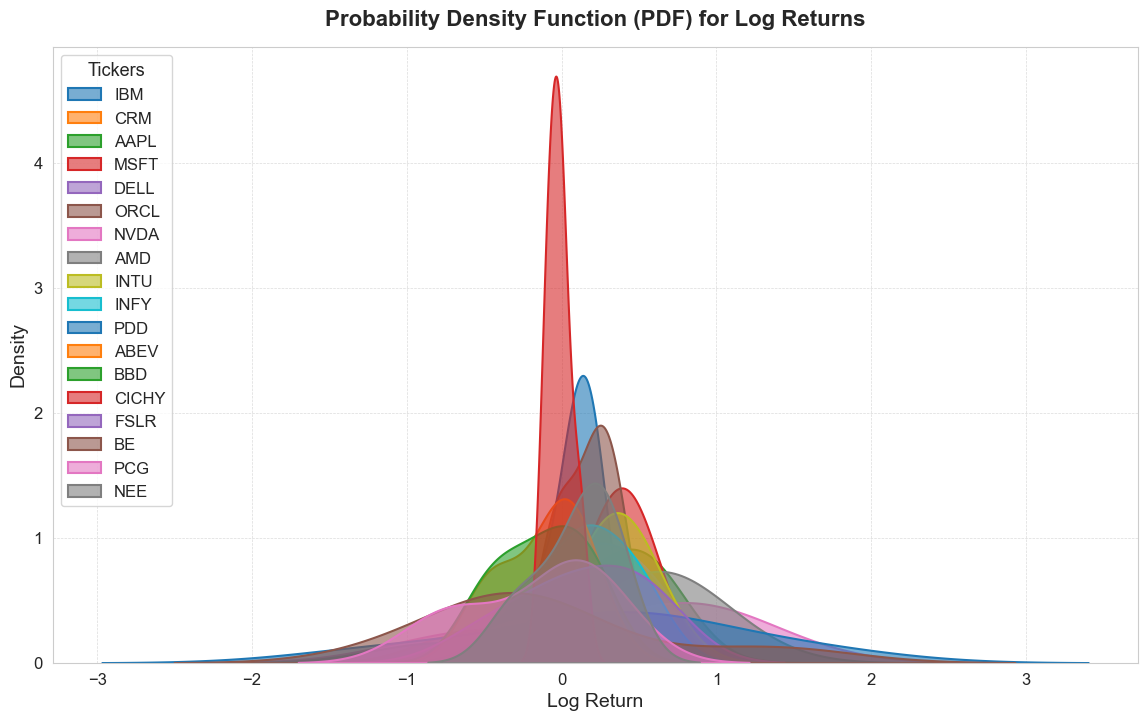

In [834]:
TranscendentalKernel().plot_pdf(yearly_log_returns)

In [839]:
pdf_dict = {}

for column in yearly_log_returns.columns:
    kde = gaussian_kde(yearly_log_returns[column])
    
    min_return = yearly_log_returns[column].min()
    max_return = yearly_log_returns[column].max()
    return_range = np.linspace(min_return, max_return, 1000)
    
    pdf_values = kde(return_range)
    
    pdf_dict[column] = {'returns': return_range, 'pdf': pdf_values}

In [842]:
simulation = TranscendentalKernel().percentile_to_percentile_mapping(10000, yearly_log_returns, vcv_matrix, pdf_dict)
simulation

Ticker,IBM,CRM,AAPL,MSFT,DELL,ORCL,NVDA,AMD,INTU,INFY,PDD,ABEV,BBD,CICHY,FSLR,BE,PCG,NEE
0,-0.261036,0.641771,0.636354,0.466238,0.663912,0.366933,1.163618,0.909987,0.211101,-0.318340,1.547090,0.198187,0.211735,0.113816,0.569674,-0.918293,0.292202,-0.329001
1,0.211687,0.641771,0.636354,-0.328848,0.663912,0.366933,1.163618,-0.002361,0.532187,-0.318340,1.547090,-0.489495,-0.504558,0.113816,0.569674,1.344607,0.292202,-0.329001
2,-0.261036,-0.650584,0.440202,-0.328848,-0.309696,0.366933,-0.698454,-0.798276,0.532187,0.520841,-1.114326,0.198187,-0.504558,-0.099765,-0.506057,-0.918293,0.292202,-0.329001
3,-0.261036,0.641771,0.636354,0.466238,0.663912,-0.047574,1.163618,-0.798276,-0.496263,-0.318340,1.547090,-0.489495,-0.504558,-0.099765,0.140465,1.344607,0.292202,-0.329001
4,-0.261036,0.641771,0.636354,0.466238,0.663912,-0.047574,1.163618,-0.538545,0.532187,0.520841,1.547090,-0.489495,0.002610,-0.099765,-0.506057,1.344607,-0.781576,-0.329001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.211687,0.641771,0.636354,-0.328848,-0.309696,0.366933,-0.698454,-0.702390,0.532187,-0.318340,-0.974111,0.198187,0.211735,0.113816,0.569674,1.344607,0.292202,0.355475
9996,-0.261036,-0.650584,-0.306582,0.466238,-0.309696,0.366933,1.163618,-0.798276,0.532187,0.520841,0.059561,-0.489495,0.211735,-0.099765,0.569674,-0.918293,0.292202,0.355475
9997,0.211687,-0.156465,0.636354,0.466238,0.602071,0.366933,0.142784,0.844814,0.532187,0.520841,-0.064284,-0.489495,0.211735,0.113816,0.569674,1.344607,0.292202,0.355475
9998,-0.261036,-0.650584,-0.306582,0.049715,-0.309696,-0.047574,-0.698454,0.909987,-0.496263,-0.318340,-1.114326,-0.489495,-0.504558,0.113816,0.569674,1.344607,-0.781576,0.355475


In [843]:
initial_value = 310000
beginning_value = OrderedDict((key, value * initial_value) for key, value in weights.items())
beginning_value

OrderedDict([('IBM', 9145.0),
             ('CRM', 31000.0),
             ('AAPL', 31000.0),
             ('MSFT', 27704.7),
             ('DELL', 31000.0),
             ('ORCL', 31000.0),
             ('NVDA', 31000.0),
             ('AMD', 25150.3),
             ('INTU', 6534.8),
             ('INFY', 3782.0000000000005),
             ('PDD', 21191.600000000002),
             ('ABEV', 16185.1),
             ('BBD', 10502.8),
             ('CICHY', 3803.7),
             ('FSLR', 3503.0),
             ('BE', 22416.1),
             ('PCG', 3546.4),
             ('NEE', 1534.5000000000002)])

In [844]:
ending_value = (beginning_value * (1 + simulation)).sum(axis=1)
ending_value

0       471834.135531
1       465354.109330
2       209562.024119
3       441154.824332
4       456835.524719
            ...      
9995    326117.418938
9996    292251.578728
9997    427979.836346
9998    258536.968371
9999    343716.414019
Length: 10000, dtype: float64

In [845]:
VaR_95_value = TranscendentalKernel().calculate_var(ending_value, 0.05)
VaR_99_value = TranscendentalKernel().calculate_var(ending_value, 0.01)

print(f"VaR at 95% confidence level (5th percentile): {VaR_95_value}")
print(f"VaR at 99% confidence level (1st percentile): {VaR_99_value}")

VaR at 95% confidence level (5th percentile): 199517.73313625593
VaR at 99% confidence level (1st percentile): 168151.74301164423


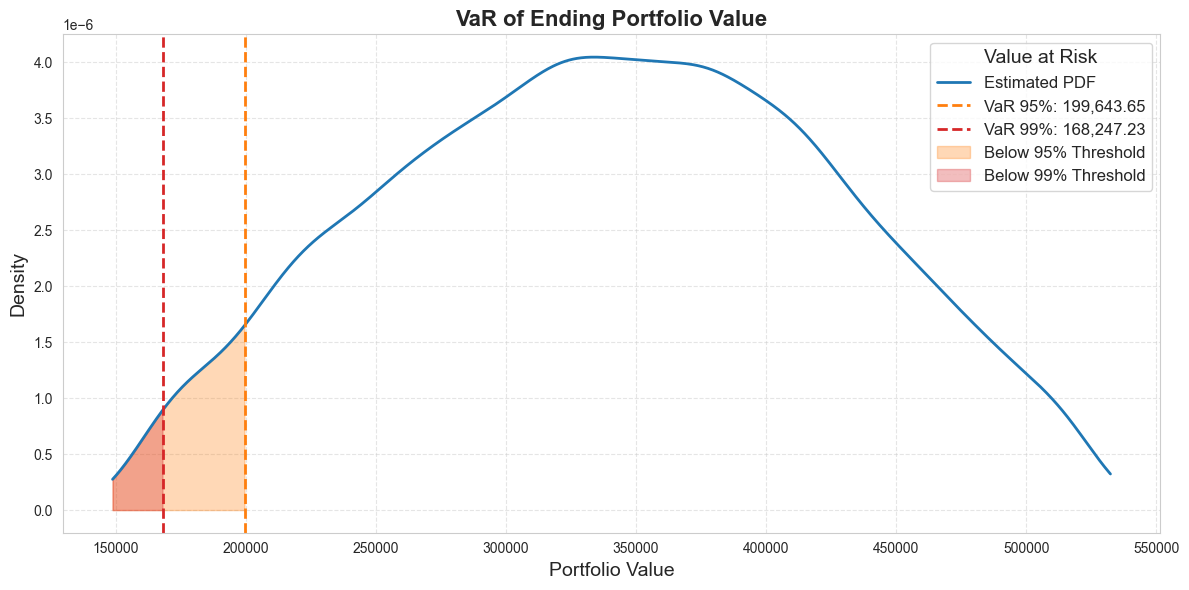

In [846]:
TranscendentalKernel().plot_var(ending_value)

# Scenario Analysis

In [744]:
bullish_data = {}
start_date = '2020-01-01'
end_date = '2021-12-31'

for ticker in portfolio.columns:
    print(f"Fetching data for ticker: {ticker}")
    bullish_data[ticker] = datafetcher.yfinance_adj_close(ticker, start=start_date, end=end_date)

bullish = pd.concat(bullish_data.values(), axis=1)
bullish.ffill(inplace=True)
bullish.bfill(inplace=True)
bullish.columns = portfolio.columns
bullish

Fetching data for ticker: IBM
Fetching data for ['IBM'] from 2020-01-01 to 2021-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: CRM
Fetching data for ['CRM'] from 2020-01-01 to 2021-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: AAPL
Fetching data for ['AAPL'] from 2020-01-01 to 2021-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: MSFT
Fetching data for ['MSFT'] from 2020-01-01 to 2021-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: DELL
Fetching data for ['DELL'] from 2020-01-01 to 2021-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: ORCL
Fetching data for ['ORCL'] from 2020-01-01 to 2021-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: NVDA
Fetching data for ['NVDA'] from 2020-01-01 to 2021-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: AMD
Fetching data for ['AMD'] from 2020-01-01 to 2021-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: INTU
Fetching data for ['INTU'] from 2020-01-01 to 2021-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: INFY
Fetching data for ['INFY'] from 2020-01-01 to 2021-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: PDD
Fetching data for ['PDD'] from 2020-01-01 to 2021-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: ABEV
Fetching data for ['ABEV'] from 2020-01-01 to 2021-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: BBD
Fetching data for ['BBD'] from 2020-01-01 to 2021-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: CICHY
Fetching data for ['CICHY'] from 2020-01-01 to 2021-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: FSLR
Fetching data for ['FSLR'] from 2020-01-01 to 2021-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: BE
Fetching data for ['BE'] from 2020-01-01 to 2021-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: PCG
Fetching data for ['PCG'] from 2020-01-01 to 2021-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Ticker,IBM,CRM,AAPL,MSFT,DELL,ORCL,NVDA,AMD,INTU,INFY,PDD,ABEV,BBD,CICHY,FSLR,BE,PCG
Date,,,,,,,,,,,,,,,,,
2020-01-02,102.597862,166.251953,72.795998,153.630707,24.737583,49.943474,5.972710,49.099998,257.685638,9.094278,41.230000,3.973188,7.093046,12.169874,57.240002,7.880000,10.825624
2020-01-03,101.779610,165.435562,72.088287,151.717712,23.923880,49.767590,5.877111,48.599998,255.962250,9.111957,40.889999,3.922788,7.112271,11.886533,57.020000,8.030000,10.546251
2020-01-06,101.597786,172.683395,72.662704,152.109894,24.165148,50.026791,5.901758,48.389999,257.927673,9.023576,40.090000,3.880789,6.927732,11.831246,55.830002,8.070000,10.356680
2020-01-07,101.665977,175.222137,72.320976,150.722977,23.559599,50.137886,5.973209,48.250000,257.985809,8.926358,41.209999,3.889189,6.804711,11.693031,56.669998,8.180000,10.556231
2020-01-08,102.514534,176.546249,73.484344,153.123749,23.654224,50.333153,5.984412,47.830002,264.191742,8.917520,40.500000,3.897588,6.697065,11.720674,56.700001,8.470000,10.586162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,114.432137,252.021194,173.438950,326.229218,52.158142,85.820633,29.590788,146.139999,623.554138,22.833822,57.709999,2.468763,2.792183,10.698004,87.370003,22.000000,11.973040
2021-12-27,115.299355,257.158356,177.423676,333.793060,52.830185,85.648438,30.893620,154.360001,640.287842,23.387817,56.959999,2.468763,2.841750,10.792054,87.860001,21.990000,11.883242
2021-12-28,116.184120,254.320984,176.400406,332.623474,53.156879,84.797142,30.271654,153.149994,637.354980,23.360115,56.040001,2.459753,2.808707,10.776379,87.349998,21.450001,12.032906


In [745]:
bullish_log_returns = dataprocessor.return_from_prices(bullish, log_returns=True)
bullish_log_returns = bullish_log_returns.resample('Y').sum() * weights_series
cov_estimator = CovarianceShrinkage(bullish_log_returns, returns_data = True, delta = optimal_shrinkage_coef)
bullish_vcv = cov_estimator.ledoit_wolf()
bullish_vcv

Ticker,IBM,CRM,AAPL,MSFT,DELL,ORCL,NVDA,AMD,INTU,INFY,PDD,ABEV,BBD,CICHY,FSLR,BE,PCG
Ticker,,,,,,,,,,,,,,,,,
IBM,0.001793,-0.005029,-0.009308,0.002863,0.002754,0.004173,0.001330,-0.004454,0.001137,-0.000335,-0.060127,0.005888,0.001485,0.000297,-0.002230,-0.036719,-0.000572
CRM,-0.005029,0.014106,0.026105,-0.008031,-0.007723,-0.011703,-0.003730,0.012491,-0.003189,0.000941,0.168636,-0.016514,-0.004165,-0.000833,0.006255,0.102984,0.001604
AAPL,-0.009308,0.026105,0.048313,-0.014863,-0.014294,-0.021659,-0.006903,0.023118,-0.005902,0.001741,0.312094,-0.030562,-0.007708,-0.001541,0.011577,0.190592,0.002969
MSFT,0.002863,-0.008031,-0.014863,0.004572,0.004397,0.006663,0.002124,-0.007112,0.001816,-0.000536,-0.096013,0.009402,0.002371,0.000474,-0.003562,-0.058634,-0.000913
DELL,0.002754,-0.007723,-0.014294,0.004397,0.004229,0.006408,0.002042,-0.006840,0.001746,-0.000515,-0.092335,0.009042,0.002281,0.000456,-0.003425,-0.056388,-0.000878
ORCL,0.004173,-0.011703,-0.021659,0.006663,0.006408,0.009710,0.003095,-0.010364,0.002646,-0.000780,-0.139912,0.013701,0.003456,0.000691,-0.005190,-0.085443,-0.001331
NVDA,0.001330,-0.003730,-0.006903,0.002124,0.002042,0.003095,0.000986,-0.003303,0.000843,-0.000249,-0.044592,0.004367,0.001101,0.000220,-0.001654,-0.027232,-0.000424
AMD,-0.004454,0.012491,0.023118,-0.007112,-0.006840,-0.010364,-0.003303,0.011062,-0.002824,0.000833,0.149337,-0.014624,-0.003688,-0.000737,0.005540,0.091199,0.001420
INTU,0.001137,-0.003189,-0.005902,0.001816,0.001746,0.002646,0.000843,-0.002824,0.000721,-0.000213,-0.038127,0.003734,0.000942,0.000188,-0.001414,-0.023284,-0.000363


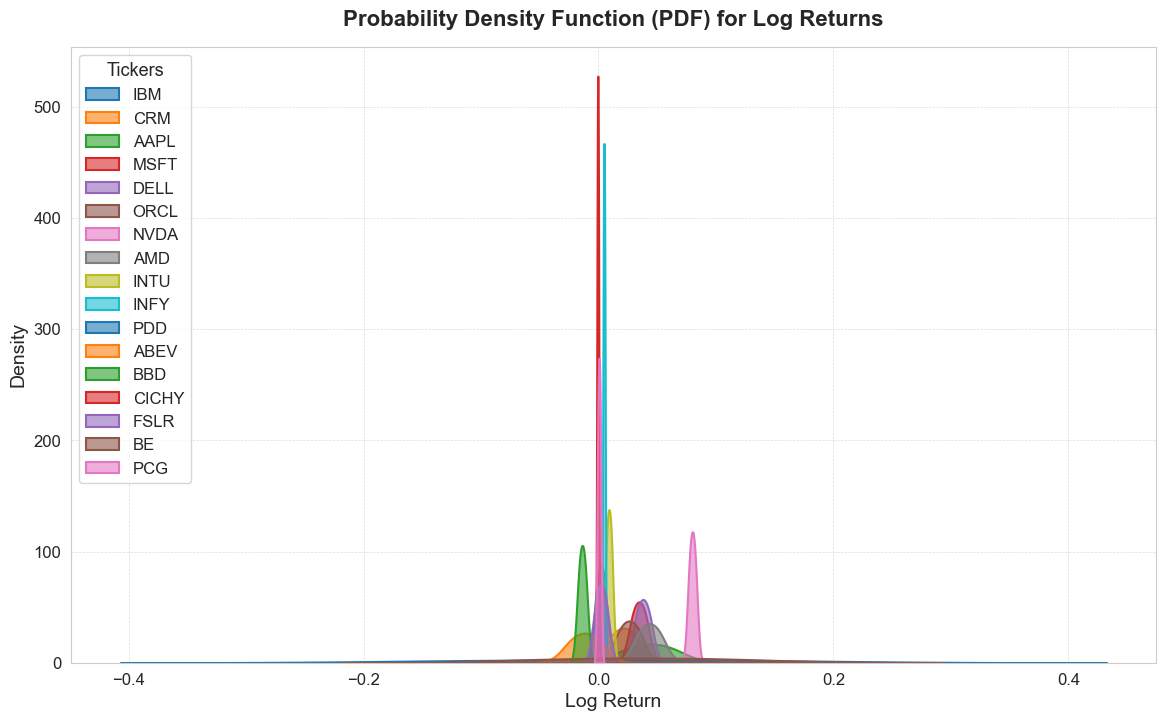

In [746]:
TranscendentalKernel().plot_pdf(bullish_log_returns)

In [747]:
pdf_dict_bullish = {}

for column in bullish_log_returns.columns:
    kde = gaussian_kde(bullish_log_returns[column])
    
    min_return = bullish_log_returns[column].min()
    max_return = bullish_log_returns[column].max()
    return_range = np.linspace(min_return, max_return, 1000)
    
    pdf_values = kde(return_range)
    
    pdf_dict_bullish[column] = {'returns': return_range, 'pdf': pdf_values}

In [ ]:
simulation = TranscendentalKernel().percentile_to_percentile_mapping(37, bullish_log_returns, bullish_vcv, pdf_dict_bullish)
port_return_in_bullish = simulation.sum(axis=1)

total_income_2024 = 222000
start_year = 2024
end_year = 2060
initial_investment = 310000
initial_wealth = initial_investment + total_income_2024
surplus_or_deficit = data = [
    68912, 85693, 105356, 51391, 78373, 186113, 397039, 470783, 557167, 608345,
    776832, 915576, 1078021, 1268202, 1490835, 1751440, 2228047, 2614239, 3066217,
    3595171, 4214188, 4901253, 5747990, 6738962, 7898699, 9255897, 10844132, 12702690,
    14877532, 17422437, 20400322, 15355583, -4178392, -4282586, -4392220, -4504661,
    -4619981, -4738252, -4859551, -4983956, -5111545, -5242401, -5376606, -5514247,
    -5655412, -5800190, -5948675, -6100961, -6257146, -6417329, -6581613, -6750102,
    -6922905, -7100131, -7281894, -7468311
]

years = list(range(start_year, end_year + 1))
port_return_in_bullish = port_return_in_bullish[:len(years)]
surplus_or_deficit = surplus_or_deficit[:len(years)]

wealth_at_beginning = [initial_wealth]
wealth_at_end = []
additions_or_drawdowns = []

wealth = initial_wealth
for i, year in enumerate(years):
    if i > 0:
        wealth_at_beginning.append(wealth_at_end[i - 1] + surplus_or_deficit[i])
    additions_or_drawdowns.append(surplus_or_deficit[i])
    wealth = wealth_at_beginning[i] * (1 + port_return_in_bullish[i])
    wealth_at_end.append(wealth)

data = {
    "Year": years,
    "Wealth at Beginning of the Year": wealth_at_beginning,
    "Return on Portfolio": port_return_in_bullish,
    "Wealth at the End of the Year": wealth_at_end,
    "Addition/Drawdown": additions_or_drawdowns,
}
bullish_case = pd.DataFrame(data)
bullish_case

,Year,Wealth at Beginning of the Year,Return on Portfolio,Wealth at the End of the Year,Addition/Drawdown
0,2024,5.320000e+05,0.183380,6.295580e+05,68912
1,2025,7.152510e+05,0.183380,8.464135e+05,85693
2,2026,9.517695e+05,0.472134,1.401133e+06,105356
3,2027,1.452524e+06,0.472134,2.138310e+06,51391
4,2028,2.216683e+06,0.472134,3.263256e+06,78373
5,2029,3.449369e+06,0.472134,5.077935e+06,186113
6,2030,5.474974e+06,0.334146,7.304413e+06,397039
7,2031,7.775196e+06,0.472134,1.144613e+07,470783
8,2032,1.200330e+07,0.472134,1.767047e+07,557167
9,2033,1.827882e+07,0.472134,2.690888e+07,608345


In [692]:
bearish_data = {}
start_date = '2007-01-01'
end_date = '2009-12-31'

for ticker in portfolio.columns:
    print(f"Fetching data for ticker: {ticker}")
    bearish_data[ticker] = datafetcher.yfinance_adj_close(ticker, start=start_date, end=end_date)

bearish = pd.concat(bearish_data.values(), axis=1)
bearish.ffill(inplace=True)
bearish.bfill(inplace=True)
bearish.columns = portfolio.columns
bearish = bearish.dropna(axis=1)
bearish.drop(columns=['CICHY'], inplace=True)
bearish.index = pd.to_datetime(bearish.index)
bearish

Fetching data for ticker: IBM
Fetching data for ['IBM'] from 2007-01-01 to 2009-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: CRM
Fetching data for ['CRM'] from 2007-01-01 to 2009-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: AAPL
Fetching data for ['AAPL'] from 2007-01-01 to 2009-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: MSFT
Fetching data for ['MSFT'] from 2007-01-01 to 2009-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: DELL
Fetching data for ['DELL'] from 2007-01-01 to 2009-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['DELL']: YFChartError("%ticker%: Data doesn't exist for startDate = 1167627600, endDate = 1262235600")


Fetching data for ticker: ORCL
Fetching data for ['ORCL'] from 2007-01-01 to 2009-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: NVDA
Fetching data for ['NVDA'] from 2007-01-01 to 2009-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: AMD
Fetching data for ['AMD'] from 2007-01-01 to 2009-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: INTU
Fetching data for ['INTU'] from 2007-01-01 to 2009-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: INFY
Fetching data for ['INFY'] from 2007-01-01 to 2009-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: PDD
Fetching data for ['PDD'] from 2007-01-01 to 2009-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['PDD']: YFChartError("%ticker%: Data doesn't exist for startDate = 1167627600, endDate = 1262235600")


Fetching data for ticker: ABEV
Fetching data for ['ABEV'] from 2007-01-01 to 2009-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: BBD
Fetching data for ['BBD'] from 2007-01-01 to 2009-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: CICHY
Fetching data for ['CICHY'] from 2007-01-01 to 2009-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: FSLR
Fetching data for ['FSLR'] from 2007-01-01 to 2009-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: BE
Fetching data for ['BE'] from 2007-01-01 to 2009-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BE']: YFChartError("%ticker%: Data doesn't exist for startDate = 1167627600, endDate = 1262235600")


Fetching data for ticker: PCG
Fetching data for ['PCG'] from 2007-01-01 to 2009-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Ticker,IBM,CRM,AAPL,MSFT,ORCL,NVDA,AMD,INTU,INFY,ABEV,BBD,FSLR,PCG
Date,,,,,,,,,,,,,
2007-01-03,52.171734,8.977645,2.524616,21.277884,14.176558,0.551474,19.520000,26.200628,4.694177,0.921068,3.996108,28.500000,31.303396
2007-01-04,52.729568,9.428145,2.580652,21.242252,14.314198,0.548876,19.790001,26.564907,4.658856,0.922756,4.038693,28.750000,30.872957
2007-01-05,52.252193,9.836333,2.562274,21.121105,14.281810,0.514485,19.709999,26.502707,4.636992,0.901655,3.870290,28.150000,30.124645
2007-01-08,53.046028,9.938380,2.574928,21.327759,14.459931,0.518306,19.469999,25.614246,4.625216,0.913050,3.998043,28.900000,30.416019
2007-01-09,53.673573,9.945847,2.788827,21.349142,14.427542,0.508218,19.650000,25.703093,4.591579,0.904188,3.911909,29.270000,30.561707
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-23,73.381630,18.069782,6.088603,23.278095,20.171684,0.415669,9.670000,27.311201,4.870413,1.988488,6.586374,132.580002,32.852360
2009-12-24,73.703346,18.084715,6.297683,23.338327,20.351145,0.414752,9.910000,27.488888,4.903693,1.988488,6.624523,133.800003,33.410294
2009-12-28,74.685547,18.323656,6.375108,23.466311,20.367455,0.408103,9.830000,27.542196,4.892308,2.029591,6.640413,134.830002,33.476383


In [693]:
weights_series.index

Index(['IBM', 'CRM', 'AAPL', 'MSFT', 'DELL', 'ORCL', 'NVDA', 'AMD', 'INTU',
       'INFY', 'PDD', 'ABEV', 'BBD', 'CICHY', 'FSLR', 'BE', 'PCG'],
      dtype='object')

In [694]:
bearish_log_returns = dataprocessor.return_from_prices(bearish, log_returns=True)
adjusted_weights_series = weights_series.drop(index=['DELL', 'BE', 'PDD', 'CICHY'])
bearish_log_returns = bearish_log_returns.resample('Y').sum() * adjusted_weights_series
cov_estimator = CovarianceShrinkage(bearish_log_returns, returns_data = True, delta = optimal_shrinkage_coef)
bearish_vcv = cov_estimator.ledoit_wolf()
bearish_vcv

Ticker,IBM,CRM,AAPL,MSFT,ORCL,NVDA,AMD,INTU,INFY,ABEV,BBD,FSLR,PCG
Ticker,,,,,,,,,,,,,
IBM,0.171622,0.102614,0.118853,0.065757,0.040085,0.154737,0.149609,0.007487,0.009666,0.050743,0.031061,0.004399,0.001818
CRM,0.102614,0.982512,1.013008,0.511453,0.325944,1.232124,0.890006,0.056463,0.062347,0.391515,0.245443,0.083194,0.010356
AAPL,0.118853,1.013008,1.430893,0.618523,0.401955,1.505752,0.926135,0.067310,0.068353,0.471742,0.298940,0.127491,0.010447
MSFT,0.065757,0.511453,0.618523,0.476974,0.201415,0.765568,0.602289,0.035599,0.041131,0.245315,0.152812,0.043812,0.007108
ORCL,0.040085,0.325944,0.401955,0.201415,0.286044,0.486198,0.341160,0.022175,0.024115,0.154075,0.096790,0.034433,0.003949
NVDA,0.154737,1.232124,1.505752,0.765568,0.486198,1.998095,1.364860,0.084728,0.094856,0.586417,0.366932,0.118685,0.015952
AMD,0.149609,0.890006,0.926135,0.602289,0.341160,1.364860,2.029462,0.071830,0.112084,0.470573,0.277435,-0.049542,0.023588
INTU,0.007487,0.056463,0.067310,0.035599,0.022175,0.084728,0.071830,0.161195,0.004803,0.027365,0.016945,0.004022,0.000857
INFY,0.009666,0.062347,0.068353,0.041131,0.024115,0.094856,0.112084,0.004803,0.164115,0.031954,0.019168,-0.000560,0.001393


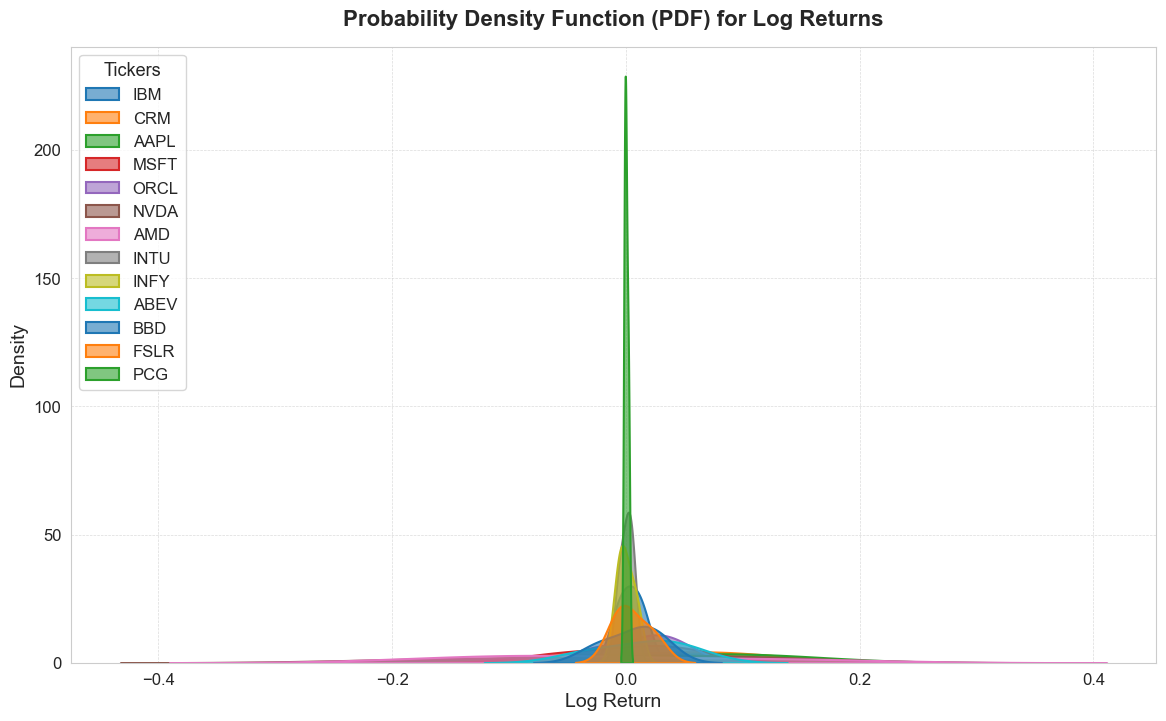

In [695]:
TranscendentalKernel().plot_pdf(bearish_log_returns)

In [696]:
pdf_dict_bearish = {}

for column in bearish_log_returns.columns:
    kde = gaussian_kde(bearish_log_returns[column])
    
    min_return = bearish_log_returns[column].min()
    max_return = bearish_log_returns[column].max()
    return_range = np.linspace(min_return, max_return, 1000)
    
    pdf_values = kde(return_range)
    
    pdf_dict_bearish[column] = {'returns': return_range, 'pdf': pdf_values}

In [772]:
def run_simulation():
    simulation = TranscendentalKernel().percentile_to_percentile_mapping(37, bearish_log_returns, bearish_vcv, pdf_dict_bearish)
    port_return_in_bearish = simulation.sum(axis=1)
    return port_return_in_bearish

indices_to_check = [12, 13, 14, 20, 21, 22, 24, 25, 26]

while True:
    port_return_in_bearish = run_simulation()
    
    if all(port_return_in_bearish[i] < 0 for i in indices_to_check):
        break

port_return_in_bearish

0     0.429318
1     0.099822
2     0.438306
3     0.541814
4    -0.093403
5    -0.102371
6    -0.509979
7     0.228024
8     0.523024
9     0.397984
10   -0.540396
11   -0.142018
12   -0.078488
13   -0.508073
14   -0.352976
15    0.054407
16    0.217722
17    0.284684
18    0.430429
19    0.488674
20   -0.533864
21   -0.427724
22   -0.221703
23   -0.157987
24   -0.462357
25   -0.445917
26   -0.258566
27   -0.302937
28    0.339779
29    0.005823
30   -0.502206
31    0.545010
32   -0.548077
33    0.402917
34    0.188221
35    0.272081
36    0.534041
dtype: float64

## Bull Scenario

In [629]:
stable_data = {}
start_date = '2010-01-01'
end_date = '2014-12-31'

for ticker in portfolio.columns:
    print(f"Fetching data for ticker: {ticker}")
    stable_data[ticker] = datafetcher.yfinance_adj_close(ticker, start=start_date, end=end_date)

stable = pd.concat(stable_data.values(), axis=1)
stable.ffill(inplace=True)
stable.bfill(inplace=True)
stable.columns = portfolio.columns
stable = stable.dropna(axis=1)
stable.drop(columns=['PCG'], inplace=True)
stable.index = pd.to_datetime(stable.index)
stable

Fetching data for ticker: IBM
Fetching data for ['IBM'] from 2010-01-01 to 2014-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: CRM
Fetching data for ['CRM'] from 2010-01-01 to 2014-12-31 with interval '1d'
Fetching data for ticker: AAPL
Fetching data for ['AAPL'] from 2010-01-01 to 2014-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: MSFT
Fetching data for ['MSFT'] from 2010-01-01 to 2014-12-31 with interval '1d'
Fetching data for ticker: DELL
Fetching data for ['DELL'] from 2010-01-01 to 2014-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['DELL']: YFChartError("%ticker%: Data doesn't exist for startDate = 1262322000, endDate = 1420002000")


Fetching data for ticker: ORCL
Fetching data for ['ORCL'] from 2010-01-01 to 2014-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: NVDA
Fetching data for ['NVDA'] from 2010-01-01 to 2014-12-31 with interval '1d'
Fetching data for ticker: AMD
Fetching data for ['AMD'] from 2010-01-01 to 2014-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Fetching data for ticker: INTU
Fetching data for ['INTU'] from 2010-01-01 to 2014-12-31 with interval '1d'



[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: INFY
Fetching data for ['INFY'] from 2010-01-01 to 2014-12-31 with interval '1d'
Fetching data for ticker: PDD
Fetching data for ['PDD'] from 2010-01-01 to 2014-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['PDD']: YFChartError("%ticker%: Data doesn't exist for startDate = 1262322000, endDate = 1420002000")
[*********************100%%**********************]  1 of 1 completed

Fetching data for ticker: ABEV
Fetching data for ['ABEV'] from 2010-01-01 to 2014-12-31 with interval '1d'



[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: BBD
Fetching data for ['BBD'] from 2010-01-01 to 2014-12-31 with interval '1d'
Fetching data for ticker: CICHY
Fetching data for ['CICHY'] from 2010-01-01 to 2014-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: FSLR
Fetching data for ['FSLR'] from 2010-01-01 to 2014-12-31 with interval '1d'
Fetching data for ticker: BE
Fetching data for ['BE'] from 2010-01-01 to 2014-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['BE']: YFChartError("%ticker%: Data doesn't exist for startDate = 1262322000, endDate = 1420002000")


Fetching data for ticker: PCG
Fetching data for ['PCG'] from 2010-01-01 to 2014-12-31 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Ticker,IBM,CRM,AAPL,MSFT,ORCL,NVDA,AMD,INTU,INFY,ABEV,BBD,CICHY,FSLR
Date,,,,,,,,,,,,,
2010-01-04,74.764572,18.622328,6.447412,23.300680,20.269571,0.423923,9.70,27.373394,4.971131,2.150750,7.098160,6.857369,135.460007
2010-01-05,73.861404,18.542683,6.458559,23.308208,20.245098,0.430113,9.71,27.373394,4.990400,2.135933,6.951246,6.854195,137.399994
2010-01-06,73.381630,18.510326,6.355828,23.165169,19.951456,0.432864,9.57,26.991358,4.914203,2.147403,6.935344,6.828809,140.020004
2010-01-07,73.127625,18.428190,6.344077,22.924259,19.886200,0.424381,9.47,26.902510,4.764439,2.139040,6.846314,6.774863,140.479996
2010-01-08,73.861404,18.455570,6.386255,23.082359,20.130907,0.425298,9.43,27.613277,4.776700,2.172973,6.916265,6.632067,139.679993
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-23,100.770096,60.232605,25.062023,41.603676,39.395382,0.495624,2.67,87.569298,6.151565,4.334581,5.378141,8.402808,44.060001
2014-12-24,100.509254,60.063358,24.943991,41.337479,39.583763,0.493704,2.65,87.053932,6.092064,4.348863,5.502441,8.292727,43.669998
2014-12-26,100.832222,60.531281,25.384926,41.114239,39.472450,0.494184,2.65,86.685776,6.103580,4.313159,5.415429,8.581035,44.340000


In [630]:
stable_log_returns = dataprocessor.return_from_prices(stable, log_returns=True)
adjusted_weights_series = weights_series.drop(index=['BE', 'PDD', 'PCG', 'DELL'])
stable_log_returns = stable_log_returns.resample('Y').sum() * adjusted_weights_series
cov_estimator = CovarianceShrinkage(stable_log_returns, returns_data = True, delta = optimal_shrinkage_coef)
stable_vcv = cov_estimator.ledoit_wolf()
stable_vcv

Ticker,IBM,CRM,AAPL,MSFT,ORCL,NVDA,AMD,INTU,INFY,ABEV,BBD,CICHY,FSLR
Ticker,,,,,,,,,,,,,
IBM,0.035033,-0.003099,-0.000351,-0.005605,-0.004678,-0.007216,-0.002506,-0.000183,-0.000685,0.003054,-0.000892,-0.000438,-0.001822
CRM,-0.003099,0.146145,0.012126,-0.003235,0.056067,-0.017181,0.001269,0.006844,0.005858,0.024335,0.003692,0.004728,0.016839
AAPL,-0.000351,0.012126,0.049703,-0.012686,0.007940,-0.013564,-0.027686,0.001560,0.000235,0.008181,0.003391,0.001034,-0.001873
MSFT,-0.005605,-0.003235,-0.012686,0.063478,0.007330,0.037566,0.036746,-0.000489,0.002352,-0.018795,-0.000248,0.000410,0.007527
ORCL,-0.004678,0.056067,0.007940,0.007330,0.067607,0.003705,-0.003033,0.003133,0.003503,0.006363,0.004073,0.003076,0.010211
NVDA,-0.007216,-0.017181,-0.013564,0.037566,0.003705,0.083483,0.048176,-0.000590,0.002941,-0.027315,-0.000367,0.000064,0.007476
AMD,-0.002506,0.001269,-0.027686,0.036746,-0.003033,0.048176,0.174291,0.004904,0.007764,-0.026697,-0.010776,-0.001815,0.013803
INTU,-0.000183,0.006844,0.001560,-0.000489,0.003133,-0.000590,0.004904,0.034222,0.000789,0.000974,-0.000096,0.000213,0.001168
INFY,-0.000685,0.005858,0.000235,0.002352,0.003503,0.002941,0.007764,0.000789,0.034217,-0.000859,-0.000104,0.000231,0.001745


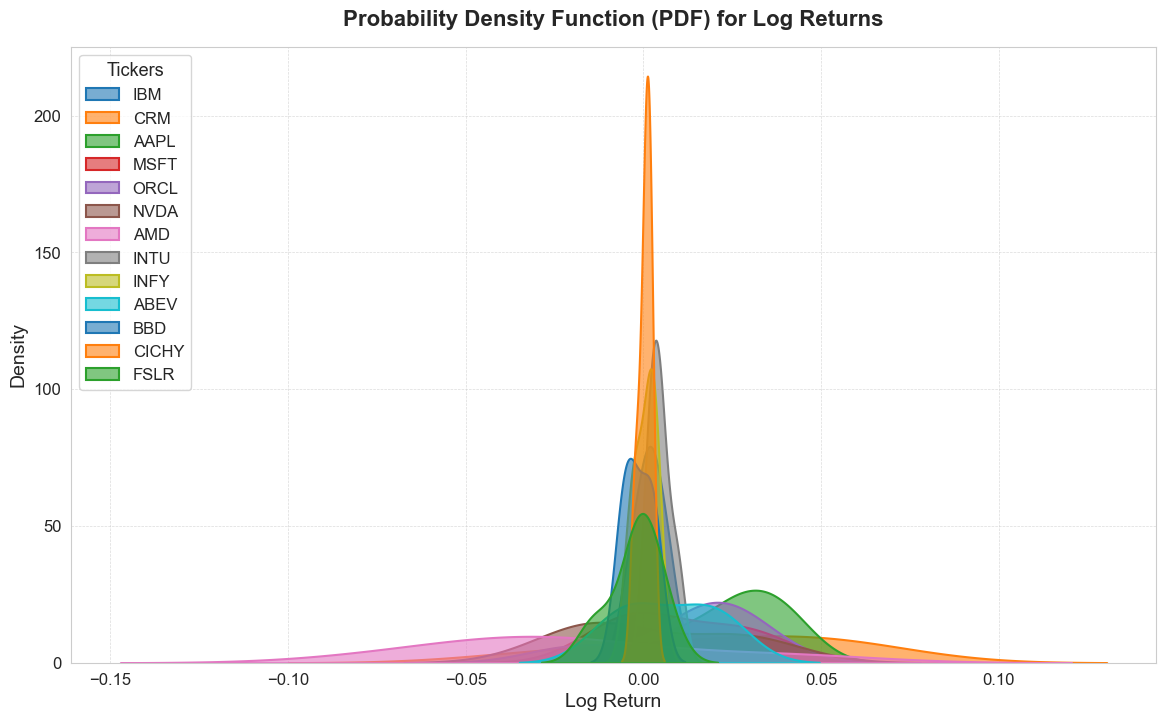

In [631]:
TranscendentalKernel().plot_pdf(stable_log_returns)

In [632]:
pdf_dict_stable = {}

for column in stable_log_returns.columns:
    kde = gaussian_kde(stable_log_returns[column])
    
    min_return = stable_log_returns[column].min()
    max_return = stable_log_returns[column].max()
    return_range = np.linspace(min_return, max_return, 1000)
    
    pdf_values = kde(return_range)
    
    pdf_dict_stable[column] = {'returns': return_range, 'pdf': pdf_values}

In [633]:
np.random.seed(42)
simulation = TranscendentalKernel().percentile_to_percentile_mapping(37, stable_log_returns, stable_vcv, pdf_dict_stable)
simulation

Ticker,IBM,CRM,AAPL,MSFT,ORCL,NVDA,AMD,INTU,INFY,ABEV,BBD,CICHY,FSLR
0,0.007268,0.056772,0.007760,-0.007450,0.027548,-0.018286,-0.064874,0.001356,-0.003800,-0.006220,0.002956,-0.002344,0.005713
1,-0.004040,-0.026314,0.007760,0.033004,-0.019191,0.028911,0.038223,0.001356,-0.003800,-0.006220,0.002956,-0.002344,0.005713
2,0.007268,0.030029,0.007760,0.033004,0.027548,0.013608,0.038223,0.009402,0.003123,-0.006220,-0.006044,0.002095,-0.013493
3,0.007268,0.056772,0.041027,-0.002523,0.027548,-0.018286,-0.019041,0.001356,-0.003800,0.020828,-0.006044,0.002095,0.005713
4,0.007268,0.056772,0.007760,0.033004,0.027548,0.028911,0.038223,0.001356,-0.003800,-0.006220,0.002956,-0.002344,0.005713
5,0.007268,0.056772,0.041027,-0.007450,0.027548,0.028911,-0.064874,0.001356,0.003123,-0.006220,-0.006044,-0.002344,-0.013493
6,-0.004040,-0.026314,0.007760,-0.007450,-0.019191,-0.018286,-0.064874,0.001356,-0.003800,0.020828,-0.006044,0.002095,0.005713
7,0.007268,-0.026314,0.041027,-0.007450,-0.013798,-0.018286,-0.064874,0.001356,0.003123,0.020828,-0.006044,-0.002344,-0.013493
8,-0.004040,0.033526,0.041027,0.033004,0.027548,0.028911,-0.064874,0.009402,-0.003800,0.020828,0.002956,0.002095,0.005713
9,0.007268,0.056772,0.007760,0.033004,0.027548,0.028911,0.038223,0.009402,0.003123,0.017046,-0.006044,-0.002344,0.005713


In [634]:
port_return_in_stable = simulation.sum(axis=1)

In [635]:
port_return_in_stable

0     0.006400
1     0.056015
2     0.146303
3     0.112912
4     0.197148
5     0.065580
6    -0.112247
7    -0.079002
8     0.132295
9     0.226382
10    0.100339
11    0.114079
12    0.023458
13    0.002323
14    0.182904
15   -0.111443
16    0.196670
17    0.149144
18    0.070198
19    0.212529
20   -0.036050
21   -0.031331
22    0.184695
23   -0.126892
24    0.157563
25    0.203692
26   -0.108661
27    0.059992
28   -0.008013
29    0.227416
30    0.096058
31   -0.066553
32    0.095859
33   -0.003466
34    0.066422
35    0.069589
36    0.085782
dtype: float64

In [636]:
total_income_2024 = 222000
start_year = 2024
end_year = 2060
initial_investment = 310000
initial_wealth = initial_investment + total_income_2024
surplus_or_deficit = [
    68912, 85693, 105356, 51391, 78373, 186113, 397039, 470783, 557167, 608345,
    776832, 915576, 1078021, 1268202, 1490835, 1751440, 2228047, 2614239, 3066217,
    3595171, 4214188, 4901253, 5747990, 6738962, 7898699, 9255897, 10844132, 12702690,
    14877532, 17422437, 20400322, 15355583, -4178392, -4282586, -4392220, -4504661,
    -4619981, -4738252, -4859551, -4983956, -5111545, -5242401, -5376606, -5514247,
    -5655412, -5800190, -5948675, -6100961, -6257146, -6417329, -6581613, -6750102,
    -6922905, -7100131, -7281894, -7468311
]

years = list(range(start_year, end_year + 1))
port_return_in_stable = port_return_in_stable[:len(years)]
surplus_or_deficit = surplus_or_deficit[:len(years)]

wealth_at_beginning = [initial_wealth]
wealth_at_end = []
additions_or_drawdowns = []

wealth = initial_wealth
for i, year in enumerate(years):
    if i > 0:
        wealth_at_beginning.append(wealth_at_end[i - 1] + surplus_or_deficit[i])
    additions_or_drawdowns.append(surplus_or_deficit[i])
    wealth = wealth_at_beginning[i] * (1 + port_return_in_stable[i])
    wealth_at_end.append(wealth)

data = {
    "Year": years,
    "Wealth at Beginning of the Year": wealth_at_beginning,
    "Return on Portfolio": port_return_in_stable,
    "Wealth at the End of the Year": wealth_at_end,
    "Addition/Drawdown": additions_or_drawdowns,
}
bull_case = pd.DataFrame(data)
bull_case

,Year,Wealth at Beginning of the Year,Return on Portfolio,Wealth at the End of the Year,Addition/Drawdown
0,2024,5.320000e+05,0.006400,5.354046e+05,68912
1,2025,6.210976e+05,0.056015,6.558881e+05,85693
2,2026,7.612441e+05,0.146303,8.726166e+05,105356
3,2027,9.240076e+05,0.112912,1.028340e+06,51391
4,2028,1.106713e+06,0.197148,1.324898e+06,78373
5,2029,1.511011e+06,0.065580,1.610103e+06,186113
6,2030,2.007142e+06,-0.112247,1.781847e+06,397039
7,2031,2.252630e+06,-0.079002,2.074668e+06,470783
8,2032,2.631835e+06,0.132295,2.980015e+06,557167
9,2033,3.588360e+06,0.226382,4.400700e+06,608345


## Bearish Scenario

In [774]:
total_income_2024 = 222000
start_year = 2024
end_year = 2060
initial_investment = 310000
initial_wealth = initial_investment + total_income_2024
surplus_or_deficit = [
    68912, 85693, 105356, 51391, 78373, 186113, 397039, 470783, 557167, 608345,
    776832, 915576, 1078021, 1268202, 1490835, 1751440, 2228047, 2614239, 3066217,
    3595171, 4214188, 4901253, 5747990, 6738962, 7898699, 9255897, 10844132, 12702690,
    14877532, 17422437, 20400322, 15355583, -4178392, -4282586, -4392220, -4504661,
    -4619981, -4738252, -4859551, -4983956, -5111545, -5242401, -5376606, -5514247,
    -5655412, -5800190, -5948675, -6100961, -6257146, -6417329, -6581613, -6750102,
    -6922905, -7100131, -7281894, -7468311
]

years = list(range(start_year, end_year + 1))
port_return_in_bearish = port_return_in_bearish[:len(years)]
surplus_or_deficit = surplus_or_deficit[:len(years)]

wealth_at_beginning = [initial_wealth]
wealth_at_end = []
additions_or_drawdowns = []

port_return_for_years = []
for i in range(len(years)):
    if (i + 1) % 12 == 0:  # Every 12th year
        port_return_for_years.append(port_return_in_bearish[i])
    else:
        port_return_for_years.append(port_return_in_stable[i])

# Insert a distress event return for the 3 years following every 12th year
for i in range(len(years)):
    if (i + 1) % 12 == 0:  # 12th year
        port_return_for_years[i+1:i+4] = port_return_in_bearish[i+1:i+4]

wealth = initial_wealth
for i, year in enumerate(years):
    if i > 0:
        wealth_at_beginning.append(wealth_at_end[i - 1] + surplus_or_deficit[i])

    return_on_portfolio = port_return_for_years[i]  # Get the return for each year
    additions_or_drawdowns.append(surplus_or_deficit[i])
    
    wealth = wealth_at_beginning[i] * (1 + return_on_portfolio)
    wealth_at_end.append(wealth)

data = {
    "Year": years,
    "Wealth at Beginning of the Year": wealth_at_beginning,
    "Return on Portfolio": [
        port_return_in_stable[i] if i == 0 
        else (port_return_in_bearish[i] if (i % 12 == 0 or (i - 12) % 12 < 4) else port_return_in_stable[i]) 
        for i in range(len(years))
    ],
    "Wealth at the End of the Year": wealth_at_end,
    "Addition/Drawdown": additions_or_drawdowns,
}

bearish_case = pd.DataFrame(data)
bearish_case

,Year,Wealth at Beginning of the Year,Return on Portfolio,Wealth at the End of the Year,Addition/Drawdown
0,2024,5.320000e+05,0.006400,5.354046e+05,68912
1,2025,6.210976e+05,0.099822,6.558881e+05,85693
2,2026,7.612441e+05,0.438306,8.726166e+05,105356
3,2027,9.240076e+05,0.541814,1.028340e+06,51391
4,2028,1.106713e+06,0.197148,1.324898e+06,78373
5,2029,1.511011e+06,0.065580,1.610103e+06,186113
6,2030,2.007142e+06,-0.112247,1.781847e+06,397039
7,2031,2.252630e+06,-0.079002,2.074668e+06,470783
8,2032,2.631835e+06,0.132295,2.980015e+06,557167
9,2033,3.588360e+06,0.226382,4.400700e+06,608345


## Base Scenario

In [775]:
total_income_2024 = 222000
start_year = 2024
end_year = 2060
initial_investment = 310000
initial_wealth = initial_investment + total_income_2024
surplus_or_deficit = [
    68912, 85693, 105356, 51391, 78373, 186113, 397039, 470783, 557167, 608345,
    776832, 915576, 1078021, 1268202, 1490835, 1751440, 2228047, 2614239, 3066217,
    3595171, 4214188, 4901253, 5747990, 6738962, 7898699, 9255897, 10844132, 12702690,
    14877532, 17422437, 20400322, 15355583, -4178392, -4282586, -4392220, -4504661,
    -4619981, -4738252, -4859551, -4983956, -5111545, -5242401, -5376606, -5514247,
    -5655412, -5800190, -5948675, -6100961, -6257146, -6417329, -6581613, -6750102,
    -6922905, -7100131, -7281894, -7468311
]

years = list(range(start_year, end_year + 1))
port_return_in_bearish = port_return_in_bearish[:len(years)]
surplus_or_deficit = surplus_or_deficit[:len(years)]

wealth_at_beginning = [initial_wealth]
wealth_at_end = []
additions_or_drawdowns = []

port_return_for_years = []
for i in range(len(years)):
    if (i + 1) % 20 == 0:  # Every 20th year
        port_return_for_years.append(port_return_in_bearish[i])
    else:
        port_return_for_years.append(port_return_in_stable[i])

# Insert a distress event return for the 3 years following every 20th year
for i in range(len(years)):
    if (i + 1) % 20 == 0:  # 20th year
        port_return_for_years[i+1:i+4] = port_return_in_bearish[i+1:i+4]

wealth = initial_wealth
for i, year in enumerate(years):
    if i > 0:
        wealth_at_beginning.append(wealth_at_end[i - 1] + surplus_or_deficit[i])

    return_on_portfolio = port_return_for_years[i]  # Get the return for each year
    additions_or_drawdowns.append(surplus_or_deficit[i])
    
    wealth = wealth_at_beginning[i] * (1 + return_on_portfolio)
    wealth_at_end.append(wealth)

data = {
    "Year": years,
    "Wealth at Beginning of the Year": wealth_at_beginning,
    "Return on Portfolio": [
        port_return_in_stable[i] if i == 0 
        else (port_return_in_bearish[i] if (i % 20 == 0 or (i - 20) % 20 < 4) else port_return_in_stable[i]) 
        for i in range(len(years))
    ],
    "Wealth at the End of the Year": wealth_at_end,
    "Addition/Drawdown": additions_or_drawdowns,
}

base_case = pd.DataFrame(data)
base_case

,Year,Wealth at Beginning of the Year,Return on Portfolio,Wealth at the End of the Year,Addition/Drawdown
0,2024,5.320000e+05,0.006400,5.354046e+05,68912
1,2025,6.210976e+05,0.099822,6.558881e+05,85693
2,2026,7.612441e+05,0.438306,8.726166e+05,105356
3,2027,9.240076e+05,0.541814,1.028340e+06,51391
4,2028,1.106713e+06,0.197148,1.324898e+06,78373
5,2029,1.511011e+06,0.065580,1.610103e+06,186113
6,2030,2.007142e+06,-0.112247,1.781847e+06,397039
7,2031,2.252630e+06,-0.079002,2.074668e+06,470783
8,2032,2.631835e+06,0.132295,2.980015e+06,557167
9,2033,3.588360e+06,0.226382,4.400700e+06,608345


# Evaluation

### Performance

In [847]:
port_data = {}
start_date = '2023-12-31'
end_date = '2024-11-26'

for ticker in portfolio.columns:
    print(f"Fetching data for ticker: {ticker}")
    port_data[ticker] = datafetcher.yfinance_adj_close(ticker, start=start_date, end=end_date)

portfolio_df = pd.concat(port_data.values(), axis=1)
portfolio_df.ffill(inplace=True)
portfolio_df.bfill(inplace=True)
portfolio_df.columns = portfolio.columns

Fetching data for ticker: IBM
Fetching data for ['IBM'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: CRM
Fetching data for ['CRM'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: AAPL
Fetching data for ['AAPL'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: MSFT
Fetching data for ['MSFT'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: DELL
Fetching data for ['DELL'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: ORCL
Fetching data for ['ORCL'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: NVDA
Fetching data for ['NVDA'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: AMD
Fetching data for ['AMD'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: INTU
Fetching data for ['INTU'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: INFY
Fetching data for ['INFY'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: PDD
Fetching data for ['PDD'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: ABEV
Fetching data for ['ABEV'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: BBD
Fetching data for ['BBD'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: CICHY
Fetching data for ['CICHY'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: FSLR
Fetching data for ['FSLR'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: BE
Fetching data for ['BE'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: PCG
Fetching data for ['PCG'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: NEE
Fetching data for ['NEE'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


In [879]:
initial_investment = 310000
num_of_shares = initial_investment / portfolio_df.iloc[-1]
num_of_shares.round()

Ticker
IBM        1371.0
CRM         914.0
AAPL       1331.0
MSFT        740.0
DELL       2150.0
ORCL       1649.0
NVDA       2279.0
AMD        2197.0
INTU        488.0
INFY      13573.0
PDD        3079.0
ABEV     142857.0
BBD      132479.0
CICHY     20667.0
FSLR       1608.0
BE        11946.0
PCG       14630.0
NEE        4045.0
Name: 2024-11-25 00:00:00, dtype: float64

In [848]:
returns_df = portfolio_df.pct_change().dropna()
port_retss = returns_df.sum(axis=1)

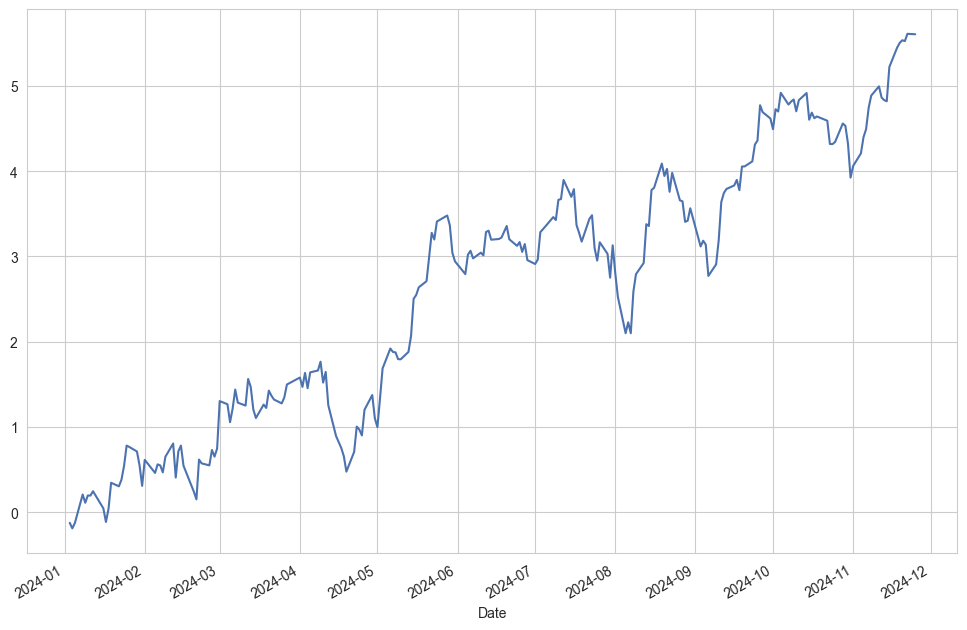

In [849]:
port_retss.cumsum().plot(figsize=(12,8));

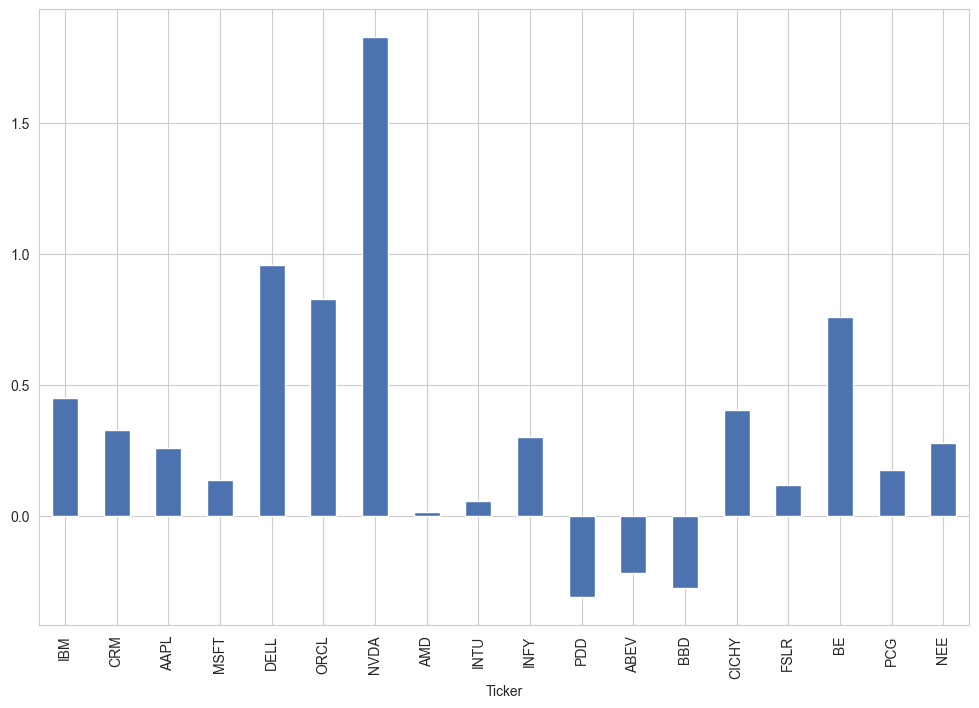

In [850]:
cumulative_returns_df = (1 + returns_df).prod() - 1
cumulative_returns_df.plot(kind='bar', figsize=(12,8));

In [ ]:
(cumulative_returns_df * 100).round(2) # cum returns

Ticker
IBM       45.08
CRM       32.99
AAPL      26.06
MSFT      13.77
DELL      95.73
ORCL      82.86
NVDA     182.45
AMD        1.84
INTU       5.74
INFY      30.36
PDD      -30.86
ABEV     -21.38
BBD      -27.30
CICHY     40.38
FSLR      12.00
BE        75.81
PCG       17.59
NEE       28.10
dtype: float64

In [ ]:
(cumulative_returns_df * stock_weights) * 100 # weighted returns

Ticker
IBM       1.329867
CRM       3.298536
AAPL      2.605625
MSFT      1.230212
DELL      9.573448
ORCL      8.286461
NVDA     18.244727
AMD       0.149287
INTU      0.120991
INFY      0.370435
PDD      -2.109847
ABEV     -1.116083
BBD      -0.924762
CICHY     0.495483
FSLR      0.135605
BE        5.482039
PCG       0.201285
NEE       0.139099
dtype: float64

In [851]:
ticker = "^IRX"

start_date = "2022-01-01"
end_date = "2024-11-26"

rf = yf.download(ticker, start=start_date, end=end_date)
rf = rf[['Adj Close']]
rf = rf.rename(columns={'Adj Close': 'rf'})
rolling_rf = rf.rolling(window=252).mean()
rolling_rf

[*********************100%%**********************]  1 of 1 completed


,rf
Date,
2022-01-03,NaN
2022-01-04,NaN
2022-01-05,NaN
2022-01-06,NaN
2022-01-07,NaN
...,...
2024-11-19,5.058925
2024-11-20,5.055639
2024-11-21,5.052298


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Portfolio Performance Metrics:
Annualized Sharpe Ratio: 1.82
Annualized Jensen's Alpha (iShares Global Tech ETF): 0.16
Annualized Jensen's Alpha (iShares MSCI Emerging Markets ETF): 0.30
Annualized Jensen's Alpha (iShares Global Clean Energy ETF): 0.47


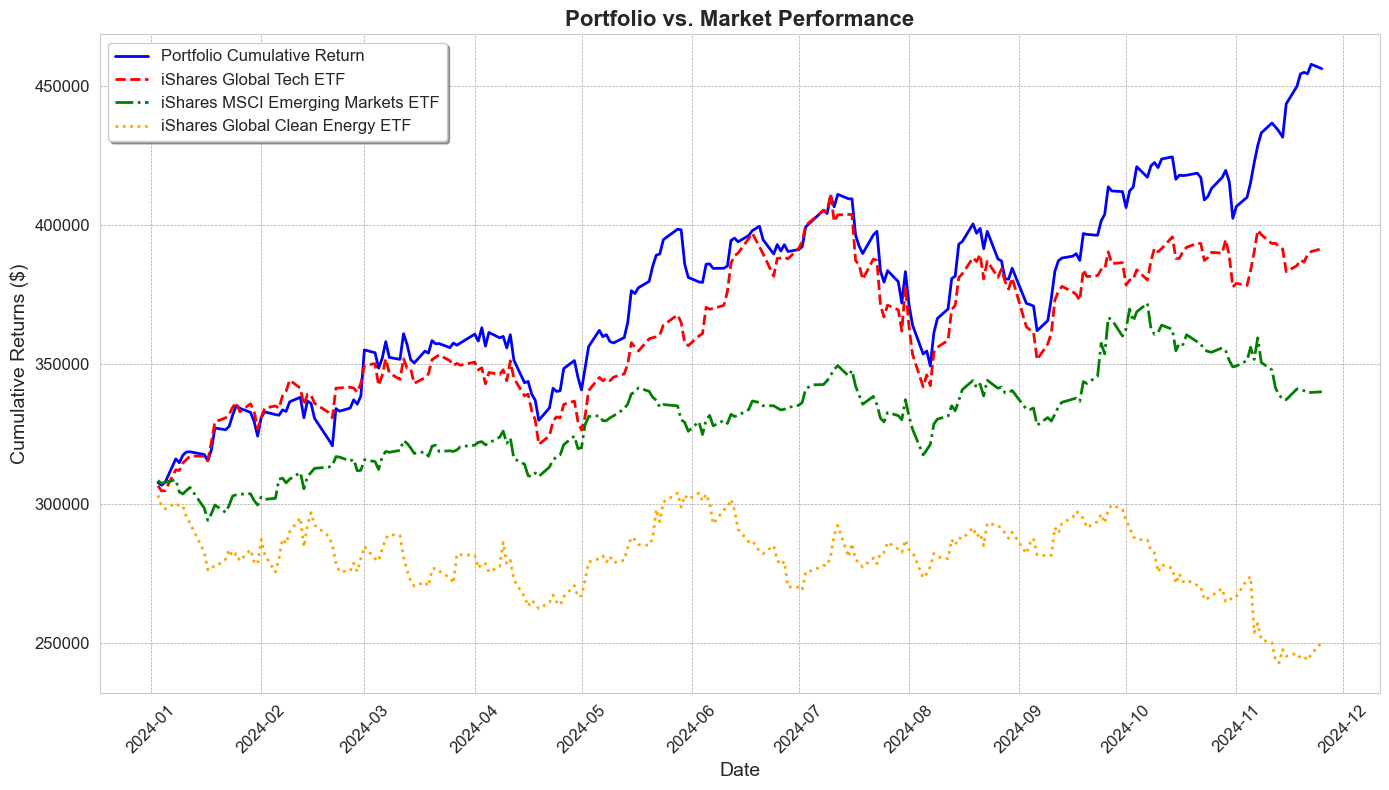

In [ ]:
start_date = '2023-12-31'
end_date = '2024-11-26'

ixn = yf.download("IXN", start=start_date, end=end_date)["Adj Close"]
msci_etf = yf.download("EEM", start=start_date, end=end_date)["Adj Close"]
global_clean_energy_index = yf.download("ICLN", start=start_date, end=end_date)["Adj Close"]

port_retss = (portfolio_df.pct_change() @ stock_weights).dropna()  # Weighted daily returns

initial_money = 310000
trading_days_per_year = 252
risk_free_rate_annual = (rolling_rf.iloc[-1].values)/100

portfolio_cum_returns = (1 + port_retss).cumprod() * initial_money

ixn_returns = ixn.pct_change().dropna()
msci_returns = msci_etf.pct_change().dropna()
global_clean_energy_returns = global_clean_energy_index.pct_change().dropna()

risk_free_rate_daily = risk_free_rate_annual / trading_days_per_year
excess_returns = port_retss - risk_free_rate_daily
sharpe_ratio = (excess_returns.mean() * trading_days_per_year) / (port_retss.std() * np.sqrt(trading_days_per_year))

excess_spdr = ixn_returns - risk_free_rate_daily
excess_msci = msci_returns - risk_free_rate_daily
excess_global_clean_energy = global_clean_energy_returns - risk_free_rate_daily

slope_spdr, intercept_spdr, _, _, _ = linregress(ixn_returns, excess_returns)
slope_msci, intercept_msci, _, _, _ = linregress(msci_returns, excess_returns)
slope_global_clean_energy, intercept_global_clean_energy, _, _, _ = linregress(global_clean_energy_returns, excess_returns)

jensen_alpha_daily_spdr = intercept_spdr
jensen_alpha_daily_msci = intercept_msci
jensen_alpha_daily_global_clean_energy = intercept_global_clean_energy

jensen_alpha_daily_spdr = jensen_alpha_daily_spdr * trading_days_per_year
jensen_alpha_daily_msci = jensen_alpha_daily_msci * trading_days_per_year
jensen_alpha_daily_global_clean_energy = jensen_alpha_daily_global_clean_energy * trading_days_per_year

# Display Results
print("Portfolio Performance Metrics:")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Annualized Jensen's Alpha (iShares Global Tech ETF): {jensen_alpha_daily_spdr:.2f}")
print(f"Annualized Jensen's Alpha (iShares MSCI Emerging Markets ETF): {jensen_alpha_daily_msci:.2f}")
print(f"Annualized Jensen's Alpha (iShares Global Clean Energy ETF): {jensen_alpha_daily_global_clean_energy:.2f}")

PortfolioPerformance().plot_performance(portfolio_cum_returns, ixn_returns, msci_returns, global_clean_energy_returns, initial_money)

In [853]:
beta_spdr, _, _, _, _ = linregress(ixn_returns, port_retss)
beta_msci, _, _, _, _ = linregress(msci_returns, port_retss)
beta_global_clean_energy, _, _, _, _ = linregress(global_clean_energy_returns, port_retss)
print(f"Beta (iShares Global Tech ETF): {beta_spdr:.2f}")
print(f"Beta (iShares MSCI Emerging Markets ETF): {beta_msci:.2f}")
print(f"Beta (iShares Global Clean Energy ETF): {beta_global_clean_energy:.2f}")

Beta (iShares Global Tech ETF): 0.87
Beta (iShares MSCI Emerging Markets ETF): 0.86
Beta (iShares Global Clean Energy ETF): 0.34


In [854]:
rolling_max = portfolio_cum_returns.cummax()
drawdown = (portfolio_cum_returns - rolling_max) / rolling_max
max_drawdown = drawdown.min()
print(f"Maximum Drawdown: {max_drawdown:.2%}")

Maximum Drawdown: -15.00%


In [855]:
downside_returns = port_retss[port_retss < 0]
sortino_ratio = excess_returns.mean() / downside_returns.std()
print(f"Sortino Ratio: {sortino_ratio:.2f}")

Sortino Ratio: 0.18


In [856]:
annualized_return = (portfolio_cum_returns.iloc[-1] / portfolio_cum_returns.iloc[0]) ** (252 / len(port_retss)) - 1
print(f"Annualized Return: {annualized_return:.2%}")

Annualized Return: 54.97%


In [857]:
corr_spdr = port_retss.corr(ixn_returns)
corr_msci = port_retss.corr(msci_returns)
corr_global_clean_energy = port_retss.corr(global_clean_energy_returns)
print(f"Correlation with iShares Global Tech ETF: {corr_spdr:.2f}")
print(f"Correlation with iShares MSCI Emerging Markets ETF: {corr_msci:.2f}")
print(f"Correlation with iShares Global Clean Energy ETF: {corr_global_clean_energy:.2f}")

Correlation with iShares Global Tech ETF: 0.87
Correlation with iShares MSCI Emerging Markets ETF: 0.61
Correlation with iShares Global Clean Energy ETF: 0.37


In [858]:
portfolio_volatility = port_retss.std() * (252 ** 0.5)  # Annualized volatility
print(f"Portfolio Volatility: {portfolio_volatility:.2%}")

Portfolio Volatility: 22.14%


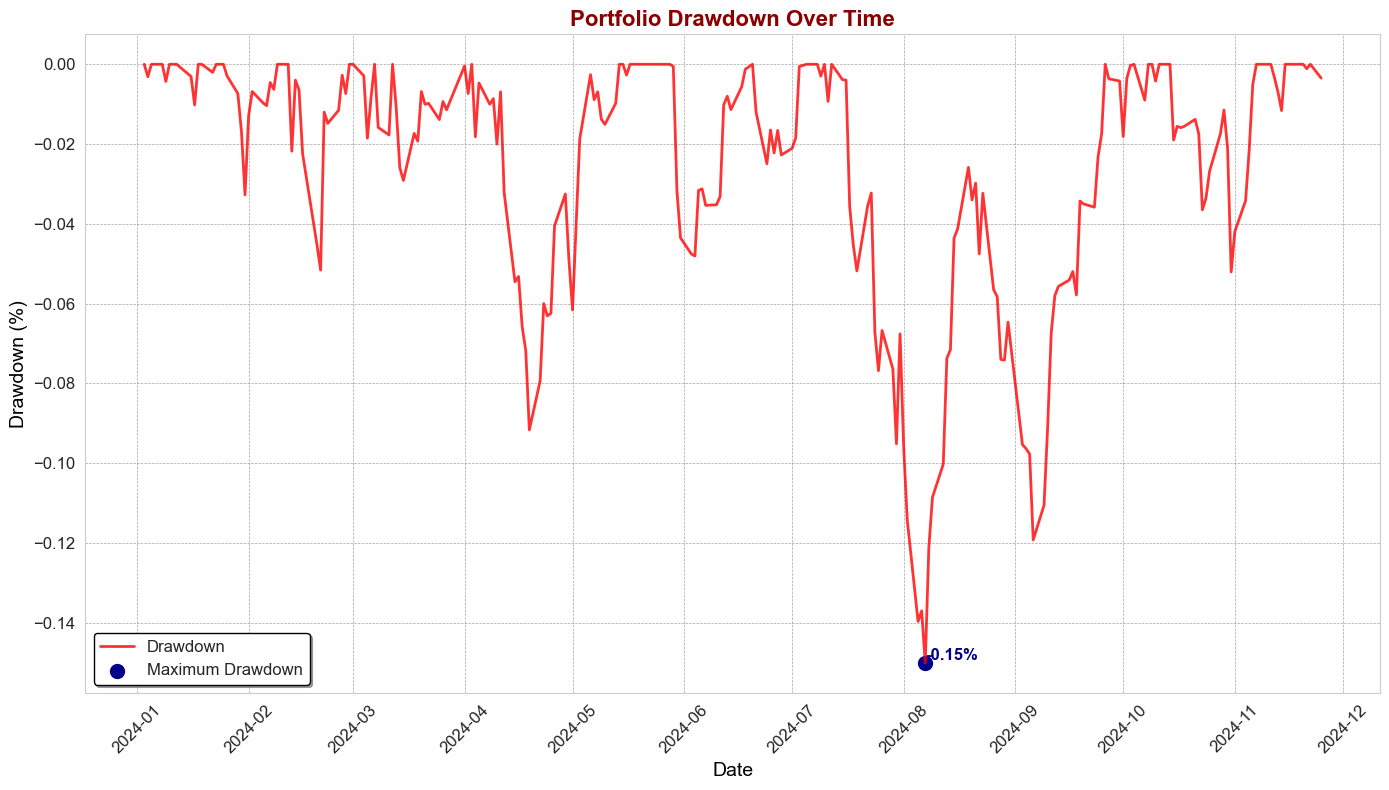

In [ ]:
PortfolioPerformance().plot_mdd(drawdown)

### Attribution

#### Allocation Effect

In [862]:
us_tech_return = (portfolio_df.iloc[:, :9].pct_change() @ stock_weights[:9]).dropna()
emerging_markets_return = (portfolio_df.iloc[:, 9:14].pct_change() @ stock_weights[9:14]).dropna()
renewable_energy_return = (portfolio_df.iloc[:, 14:].pct_change() @ stock_weights[14:]).dropna()

In [863]:
# hand collecting data (from index info via ishares.com)
us_tech_weights_in_ixn = [1.33, 2.21, 19.17, 16.87, 0.22, 1.86, 8.91, 1.44, 1.13]
emerging_markets_weights_in_msci = [0.94, 0.87, 0.14, 0.14, 1.03]
renewable_energy_weights_in_global_clean_energy = [8.15, 6.42, 1.23, 2.86]

us_tech_ticker_return = portfolio_df.iloc[:, :9].pct_change().sum(axis=0)
emerging_markets_ticker_return = portfolio_df.iloc[:, 9:14].pct_change().sum(axis=0)
renewable_energy_ticker_return = portfolio_df.iloc[:, 14:].pct_change().sum(axis=0)

In [864]:
us_tech_allocation_effect = np.sum((np.array(stock_weights[:9]) - np.array(us_tech_weights_in_ixn)/100) * np.array(us_tech_ticker_return))
emerging_markets_allocation_effect = np.sum((np.array(stock_weights[9:14]) - np.array(emerging_markets_weights_in_msci)/100) * np.array(emerging_markets_ticker_return))
renewable_energy_allocation_effect = np.sum((np.array(stock_weights[14:]) - np.array(renewable_energy_weights_in_global_clean_energy)/100) * np.array(renewable_energy_ticker_return))

print(f"US Tech Allocation Effect: {us_tech_allocation_effect:.2f}")
print(f"Emerging Markets Allocation Effect: {emerging_markets_allocation_effect:.2f}")
print(f"Renewable Energy Allocation Effect: {renewable_energy_allocation_effect:.2f}")

US Tech Allocation Effect: 0.15
Emerging Markets Allocation Effect: -0.03
Renewable Energy Allocation Effect: -0.02


In [865]:
return_each_ticker_in_ixn = us_tech_ticker_return * us_tech_weights_in_ixn/100
return_each_ticker_in_msci = emerging_markets_ticker_return * emerging_markets_weights_in_msci/100
return_each_ticker_in_global_clean_energy = renewable_energy_ticker_return * renewable_energy_weights_in_global_clean_energy/100

### Selection Effect

In [866]:
us_tech_selection_effect = (np.array(stock_weights[:9]) * (np.array(us_tech_ticker_return) - np.array(return_each_ticker_in_ixn))).sum()
emerging_markets_selection_effect = (np.array(stock_weights[9:14]) * (np.array(emerging_markets_ticker_return) - np.array(return_each_ticker_in_msci))).sum()
renewable_energy_selection_effect = (np.array(stock_weights[14:]) * (np.array(renewable_energy_ticker_return) - np.array(return_each_ticker_in_global_clean_energy))).sum()

print(f"US Tech Selection Effect: {us_tech_selection_effect:.2f}")
print(f"Emerging Markets Selection Effect: {emerging_markets_selection_effect:.2f}")
print(f"Renewable Energy Selection Effect: {renewable_energy_selection_effect:.2f}")

US Tech Selection Effect: 0.34
Emerging Markets Selection Effect: -0.03
Renewable Energy Selection Effect: 0.07


In [867]:
us_tech_interaction_effect = np.sum((np.array(stock_weights[:9]) - np.array(us_tech_weights_in_ixn)/100) * (np.array(us_tech_ticker_return) - np.array(return_each_ticker_in_ixn)))
emerging_markets_interaction_effect = np.sum((np.array(stock_weights[9:14]) - np.array(emerging_markets_weights_in_msci)/100) * (np.array(emerging_markets_ticker_return) - np.array(return_each_ticker_in_msci)))
renewable_energy_interaction_effect = np.sum((np.array(stock_weights[14:]) - np.array(renewable_energy_weights_in_global_clean_energy)/100) * (np.array(renewable_energy_ticker_return) - np.array(return_each_ticker_in_global_clean_energy)))

print(f"US Tech Interaction Effect: {us_tech_interaction_effect:.2f}")
print(f"Emerging Markets Interaction Effect: {emerging_markets_interaction_effect:.2f}")
print(f"Renewable Energy Interaction Effect: {renewable_energy_interaction_effect:.2f}")

US Tech Interaction Effect: 0.16
Emerging Markets Interaction Effect: -0.03
Renewable Energy Interaction Effect: -0.01


In [868]:
attribution_table = pd.DataFrame(
    {
        "US Tech": [us_tech_allocation_effect, us_tech_selection_effect, us_tech_interaction_effect],
        "Emerging Markets": [emerging_markets_allocation_effect, emerging_markets_selection_effect, emerging_markets_interaction_effect],
        "Renewable Energy": [renewable_energy_allocation_effect, renewable_energy_selection_effect, renewable_energy_interaction_effect],
    },
    index=["Allocation Effect", "Selection Effect", "Interaction Effect"]
)
attribution_table.round(2)

,US Tech,Emerging Markets,Renewable Energy
Allocation Effect,0.15,-0.03,-0.02
Selection Effect,0.34,-0.03,0.07
Interaction Effect,0.16,-0.03,-0.01
